# Sistem Rekomendasi Film - Faturohman Wicaksono

# Business Understanding
Problem Statements:

  - Pernyataan Masalah 1: Bagaimana membantu pengguna menavigasi dan menemukan film yang paling relevan dengan selera mereka di tengah lautan konten yang terus bertambah?

  - Pernyataan Masalah 2:Bagaimana menciptakan rekomendasi film yang lebih cerdas dan personal dengan mengintegrasikan wawasan dari data perilaku penonton serta karakteristik intrinsik film, demi melampaui batasan metode rekomendasi tunggal?

Goals:

  - Jawaban untuk Pernyataan Masalah 1:Membangun sistem rekomendasi film yang adaptif dan komprehensif dengan Content-Based Filtering dan Collaborative Filtering untuk meningkatkan relevansi dan pengalaman personalisasi.

  - Jawaban untuk Pernyataan Masalah 2: Menyajikan rekomendasi Top-N film yang disesuaikan secara individual untuk setiap pengguna, disertai dengan tingkat akurasi prediksi yang dapat dipertanggungjawabkan.

Solution Statements

  - Content-Based Filtering (Pendekatan Berbasis Konten):

    Tujuan: Untuk mengidentifikasi dan menyarankan film-film yang memiliki karakteristik konten yang serupa dengan apa yang disukai pengguna di masa lalu.

    Metodologi Implementasi:
    - Memanfaatkan genre film sebagai atribut metadata utama.
    - Menggunakan TF-IDF Vectorization untuk mengubah deskripsi genre menjadi representasi numerik yang terbobot, menunjukkan relevansi unik setiap genre dalam konteks film.
    - Mengukur tingkat kesamaan antar film melalui perhitungan Cosine Similarity dari vektor TF-IDF genre mereka, sehingga film dengan profil genre yang serupa akan memiliki skor kesamaan yang tinggi.

  - Collaborative Filtering (Pendekatan Kolaboratif Berbasis Jaringan Saraf):

    Tujuan: Untuk memprediksi preferensi rating pengguna terhadap film yang belum mereka tonton, berdasarkan pola interaksi kolektif dari seluruh basis pengguna.
    
    Metodologi Implementasi:
    - Menggunakan arsitektur Neural Network (RecommenderNet) yang melibatkan embedding (representasi vektor padat) untuk setiap pengguna dan film. Embedding ini secara implisit menangkap fitur-fitur laten yang membentuk preferensi dan karakteristik.
    - Prediksi rating dihasilkan dari produk titik (dot product) antara embedding pengguna dan film, ditambah dengan bias khusus pengguna dan film, yang mewakili kecenderungan rata-rata masing-masing.
    - Dibangun menggunakan framework TensorFlow/Keras untuk skalabilitas dan efisiensi.
    - Pelatihan model dioptimalkan dengan algoritma Adam, meminimalkan fungsi kerugian Mean Squared Error (MSE), dan kinerja dipantau menggunakan metrik Mean Absolute Error (MAE).
    - Integrasi callback Early Stopping diterapkan selama proses pelatihan untuk secara otomatis menghentikan pelatihan pada titik optimal, mencegah overfitting dan memastikan model yang dihasilkan memiliki kemampuan generalisasi terbaik.


# Data Understanding


## Data Loading

**Importing Library**


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')
#Preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

2025-06-04 21:54:16.677907: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749048856.728668   58264 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749048856.739934   58264 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749048856.836217   58264 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749048856.836237   58264 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749048856.836238   58264 computation_placer.cc:177] computation placer alr

In [2]:
# Melihat beberapa baris pertama dari dataset dan memuat data
movies = pd.read_csv('/home/crxtan/Downloads/Movie/movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [3]:
rating= pd.read_csv('/home/crxtan/Downloads/Movie/ratings.csv')
rating.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


## Exploratory Data Analysis (EDA)

In [4]:
#Cek tipe data dari dataframe movies
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62423 entries, 0 to 62422
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  62423 non-null  int64 
 1   title    62423 non-null  object
 2   genres   62423 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.4+ MB


In [5]:
#Cek tipe data dari dataframe rating
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000095 entries, 0 to 25000094
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 762.9 MB


In [6]:
#Cek jumlah baris dan kolom untuk dataset movies dan rating
movies_row = movies.shape[0]
movies_col = movies.shape[1]
rating_row = rating.shape[0]
rating_col = rating.shape[1]
print(f"movies dataset memiliki {movies_row} baris dan {movies_col} kolom.")
print(f"rating dataset memiliki {rating_row} baris dan {rating_col} kolom.")

movies dataset memiliki 62423 baris dan 3 kolom.
rating dataset memiliki 25000095 baris dan 4 kolom.


In [7]:
#Melihat sebaran data deskriptif dari movies dan rating
print("Movies Dataset:")
print(movies.describe())
print("\nRating Dataset:")
print(rating.describe())

Movies Dataset:
             movieId
count   62423.000000
mean   122220.387646
std     63264.744844
min         1.000000
25%     82146.500000
50%    138022.000000
75%    173222.000000
max    209171.000000

Rating Dataset:
             userId       movieId        rating     timestamp
count  2.500010e+07  2.500010e+07  2.500010e+07  2.500010e+07
mean   8.118928e+04  2.138798e+04  3.533854e+00  1.215601e+09
std    4.679172e+04  3.919886e+04  1.060744e+00  2.268758e+08
min    1.000000e+00  1.000000e+00  5.000000e-01  7.896520e+08
25%    4.051000e+04  1.196000e+03  3.000000e+00  1.011747e+09
50%    8.091400e+04  2.947000e+03  3.500000e+00  1.198868e+09
75%    1.215570e+05  8.623000e+03  4.000000e+00  1.447205e+09
max    1.625410e+05  2.091710e+05  5.000000e+00  1.574328e+09


In [8]:
#Cek duplikasi dari movies dan rating
print("Movies Dataset:")
print(f"Jumlah duplikasi: {movies.duplicated().sum()}")
print("\nRating Dataset:")
print(f"Jumlah duplikasi: {rating.duplicated().sum()}")

Movies Dataset:
Jumlah duplikasi: 0

Rating Dataset:
Jumlah duplikasi: 0


In [9]:
#Cek missing values
print("Movies Dataset:")
print(movies.isnull().sum())
print("\nRating Dataset:")
print(rating.isnull().sum())

Movies Dataset:
movieId    0
title      0
genres     0
dtype: int64

Rating Dataset:
userId       0
movieId      0
rating       0
timestamp    0
dtype: int64


Pengecekan diatas menunjukan dari kedua dataframe tidak memiliki missing values.

### Univariate Data Analysis

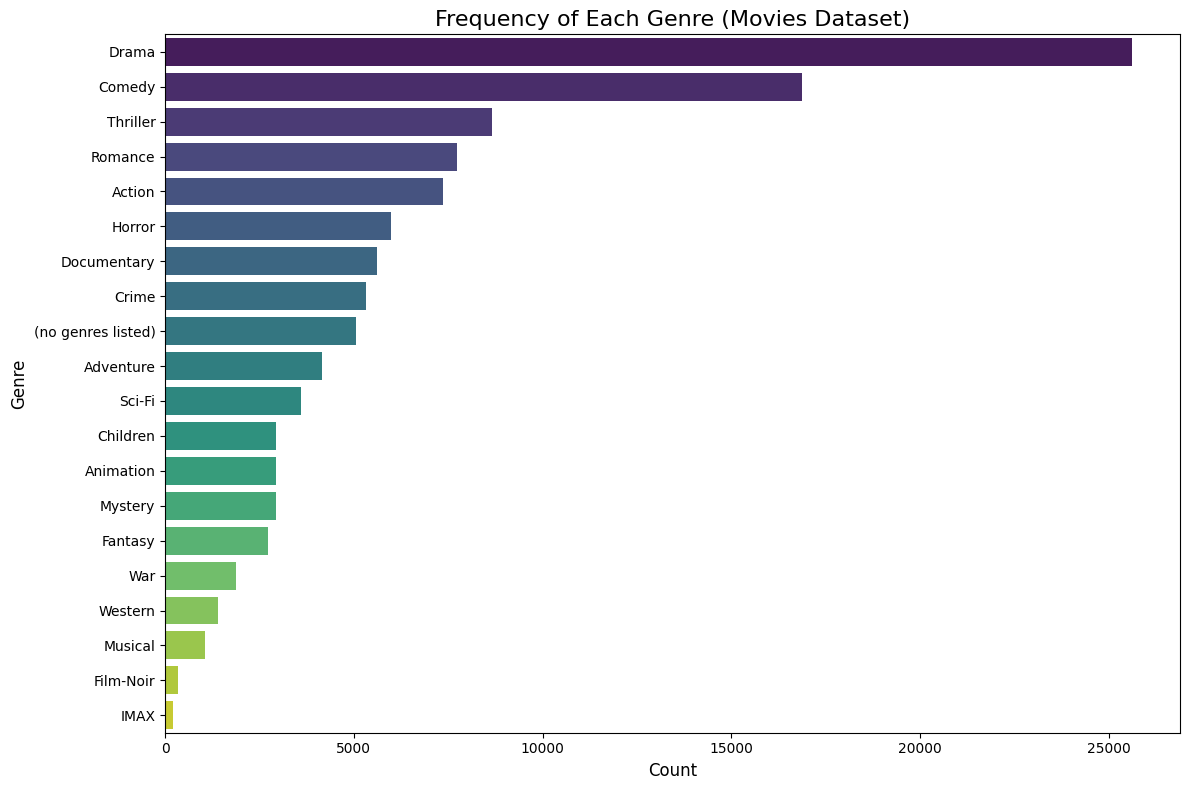

In [10]:
# Analisis Univariat untuk Frekuensi Genre dalam movies dataset

all_genres = movies['genres'].str.split('|', expand=True).stack()

plt.figure(figsize=(12, 8))
sns.countplot(y=all_genres, order=all_genres.value_counts().index, palette='viridis')
plt.title('Frequency of Each Genre (Movies Dataset)', fontsize=16)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.tight_layout()
plt.show()

Analisis:

  - Dominasi Genre Drama: Genre "Drama" adalah yang paling sering muncul dalam dataset, dengan jumlah kemunculan jauh di atas genre lainnya (lebih dari 25.000). Ini menunjukkan bahwa film bergenre drama sangat banyak diproduksi atau populer dalam dataset ini.

  - Genre Populer Lainnya: "Comedy" juga sangat populer, menempati posisi kedua dengan jumlah kemunculan sekitar 16.000. Diikuti oleh "Thriller" dan "Romance" yang masing-masing memiliki sekitar 8.000-9.000 kemunculan.

  - Genre dengan Frekuensi Sedang: "Action", "Horror", "Documentary", "Crime", dan "(no genres listed)" (kemungkinan kategori untuk film yang tidak memiliki genre spesifik terdaftar) memiliki frekuensi yang cukup mirip, berkisar antara 4.000 hingga 7.000.

  - Genre Kurang Populer: Genre-genre seperti "Adventure", "Sci-Fi", "Children", "Animation", "Mystery", "Fantasy", "War", "Western", "Musical", "Film-Noir", dan "IMAX" memiliki frekuensi yang jauh lebih rendah, dengan "IMAX" menjadi yang paling jarang muncul (kurang dari 1.000).

  - Persebaran yang Tidak Merata: Distribusi genre dalam dataset ini sangat tidak merata, dengan beberapa genre yang sangat mendominasi dan banyak genre lain yang jarang muncul.

Insight:

  - Preferensi Produksi/Konsumsi: Dataset ini kemungkinan besar mencerminkan preferensi produksi film atau preferensi penonton yang lebih condong ke genre drama dan komedi. Produser film mungkin menemukan bahwa genre-genre ini memiliki pasar yang lebih besar atau lebih mudah untuk diproduksi.

  - Kesenjangan Konten: Ada kesenjangan yang signifikan dalam representasi genre. Jika dataset ini digunakan untuk rekomendasi film, sistem mungkin akan lebih sering merekomendasikan film drama atau komedi karena ketersediaan datanya yang melimpah.

  - Potensi Pasar Niche: Meskipun beberapa genre jarang, ini bisa menunjukkan potensi pasar niche yang belum sepenuhnya dieksplorasi. Misalnya, meskipun "IMAX" jarang, jika ada permintaan yang signifikan untuk film-film tersebut, ini bisa menjadi area pertumbuhan.

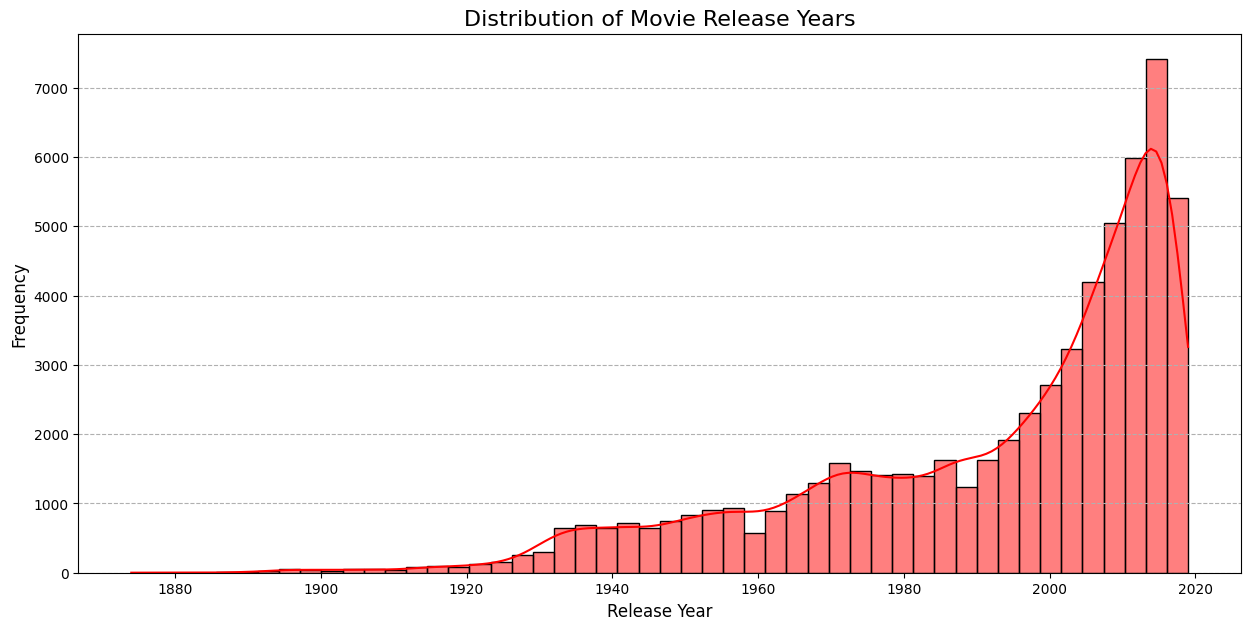

In [12]:
# Analisis Univariat untuk Distribusi Tahun Rilis (dari judul film)

# Ekstraksi tahun dari kolom 'title'
# Menggunakan regex untuk mencari 4 digit angka dalam kurung di akhir string
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)').astype(float)

# Visualisasi distribusi tahun
plt.figure(figsize=(15, 7))
sns.histplot(data=movies, x='year', bins=50, kde=True, color='red')
plt.title('Distribution of Movie Release Years', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.show()

Analisis:

  - Peningkatan Produksi Film yang Konsisten: Secara keseluruhan, terlihat jelas tren peningkatan jumlah film yang dirilis dari waktu ke waktu. Dimulai dari frekuensi yang sangat rendah di akhir abad ke-19, jumlah film yang dirilis terus meningkat.

  - Periode Awal (Pra-1940-an): Pada periode awal perfilman (sebelum sekitar tahun 1940), jumlah film yang dirilis sangat rendah. Ada peningkatan bertahap yang lambat.

  - Pertumbuhan Pasca-Perang Dunia (1940-an - 1980-an): Setelah sekitar tahun 1940-an, frekuensi rilis film mulai menunjukkan pertumbuhan yang lebih nyata, meskipun masih relatif stabil di angka ratusan hingga sekitar 1500 film per tahun pada periode 1960-an hingga 1980-an.

  - Akselerasi di Era Modern (Akhir 1990-an - 2010-an): Terjadi peningkatan yang sangat tajam dalam jumlah rilis film mulai akhir tahun 1990-an hingga puncak di sekitar tahun 2010-an. Ini adalah periode dengan pertumbuhan produksi film yang paling pesat.

  - Puncak Produksi (Sekitar 2010-2015): Jumlah film yang dirilis mencapai puncaknya di sekitar tahun 2010-2015, dengan frekuensi tertinggi mendekati 7500 film per tahun.

  - Penurunan Ringan Menjelang Akhir Data (Setelah 2015): Ada sedikit penurunan frekuensi setelah puncaknya, sekitar tahun 2015 hingga menjelang tahun 2020. Ini mungkin menunjukkan sedikit perlambatan, atau bisa juga karena data untuk tahun-tahun terakhir belum sepenuhnya lengkap.

Insight:

  - Evolusi Industri Film: Grafik ini dengan jelas menggambarkan evolusi dan pertumbuhan industri film selama lebih dari satu abad. Peningkatan yang eksponensial di era modern menunjukkan bahwa pembuatan film menjadi lebih mudah diakses, lebih terjangkau, atau permintaan akan konten film meningkat drastis.

  - Dampak Teknologi: Peningkatan tajam di akhir abad ke-20 dan awal abad ke-21 kemungkinan besar didorong oleh kemajuan teknologi. Digitalisasi dalam produksi, distribusi, dan konsumsi film (misalnya, kemunculan DVD, Blu-ray, internet, dan platform streaming) telah memungkinkan lebih banyak film untuk diproduksi dan didistribusikan.

  - Demokratisasi Pembuatan Film: Alat-alat produksi yang semakin terjangkau dan platform distribusi digital (seperti YouTube, Vimeo, dan platform film indie) telah memungkinkan lebih banyak individu dan kelompok kecil untuk membuat dan merilis film, bukan hanya studio besar. Ini bisa menjelaskan lonjakan frekuensi.

  - Perubahan Lanskap Media: Peningkatan ini juga mencerminkan perubahan dalam lanskap media secara keseluruhan, di mana konten visual menjadi semakin sentral dalam konsumsi hiburan.

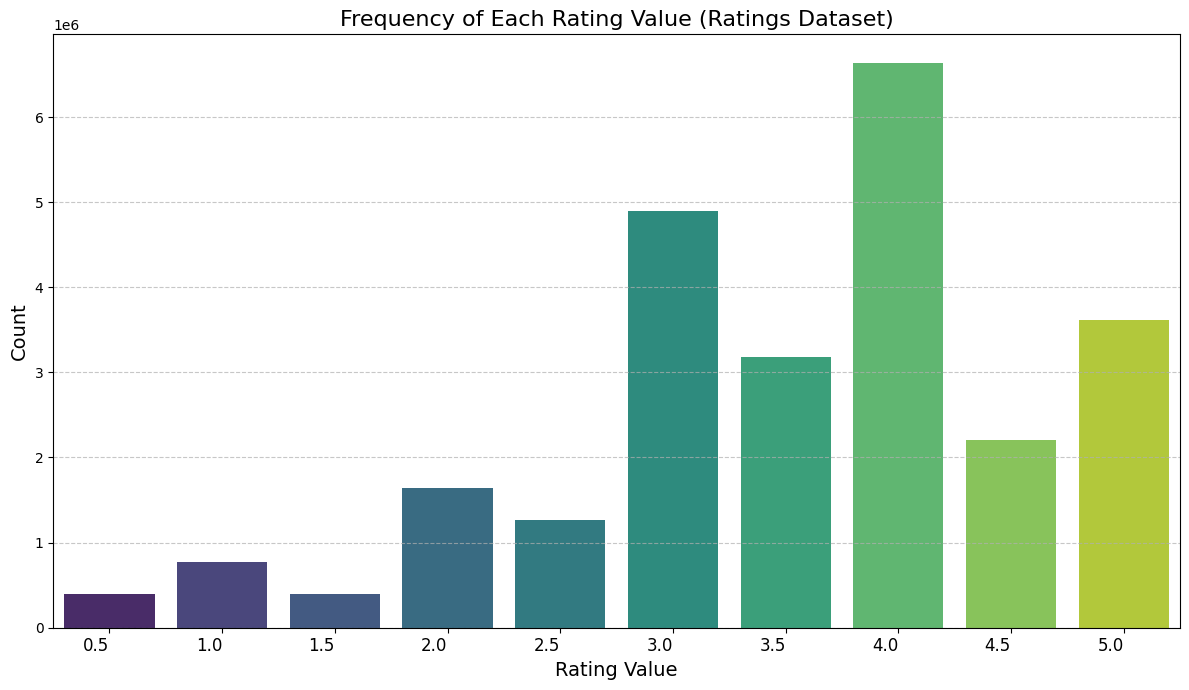

In [15]:
# Analisis Univariat untuk Frekuensi Nilai Rating

plt.figure(figsize=(12, 7))
rating_order = sorted(rating['rating'].unique())

sns.countplot(data=rating, x='rating', order=rating_order, palette='viridis')
plt.title('Frequency of Each Rating Value (Ratings Dataset)', fontsize=16)
plt.xlabel('Rating Value', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=np.arange(len(rating_order)), labels=rating_order, ha='right', fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Analisis:

Dari grafik, kita dapat mengamati hal-hal berikut:

  - Rating Paling Dominan adalah 4.0: Nilai rating 4.0 memiliki frekuensi tertinggi, yaitu di atas 6 juta. Ini menunjukkan bahwa nilai 4.0 adalah rating yang paling sering diberikan oleh pengguna dalam dataset ini.

  - Rating Populer Lainnya:
      - Rating 3.0 menempati posisi kedua dengan frekuensi mendekati 5 juta.
      - Rating 5.0 berada di posisi ketiga dengan frekuensi sekitar 3.5 juta.
      - Rating 3.5 dan 4.5 juga cukup sering diberikan, masing-masing di atas 3 juta dan di atas 2 juta.

  - Penurunan Frekuensi Seiring Penurunan Rating (secara umum): Secara umum, semakin rendah nilai rating, semakin rendah pula frekuensinya.
      - Rating 2.0 dan 2.5 memiliki frekuensi di atas 1 juta.
      - Rating 1.0 dan 1.5 memiliki frekuensi di bawah 1 juta.
      - Rating 0.5 adalah yang paling jarang diberikan, dengan frekuensi kurang dari 500 ribu.

  - Distribusi Preferensi Positif: Sebagian besar rating cenderung berada di sisi positif (yaitu 3.0 ke atas), menunjukkan bahwa secara keseluruhan, item yang diberi rating dalam dataset ini diterima dengan cukup baik oleh pengguna. Rating di bawah 3.0 memiliki frekuensi yang jauh lebih rendah.

Insight:

  - Kepuasan Pengguna Cenderung Tinggi: Distribusi rating yang condong ke nilai-nilai yang lebih tinggi (terutama 4.0, 3.0, dan 5.0) menunjukkan bahwa mayoritas pengguna merasa puas atau cukup puas dengan item yang mereka nilai. Jika ini adalah dataset rating film, ini berarti sebagian besar film diterima dengan baik.

  - Sistem Rating Terbiasa pada Nilai Tertentu: Orang-orang mungkin cenderung memilih nilai "bulat" seperti 4.0, 3.0, atau 5.0 daripada nilai setengah seperti 3.5 atau 4.5, meskipun nilai setengah juga cukup sering digunakan. Preferensi untuk 4.0 sebagai yang tertinggi menunjukkan "sweet spot" bagi pengguna, mungkin sebagai bentuk rating "sangat bagus tapi tidak sempurna."

  - Ulasan Negatif Lebih Jarang Diberikan: Fakta bahwa rating rendah (1.0, 0.5) jauh lebih jarang menunjukkan bahwa pengguna lebih jarang memberikan rating yang sangat negatif. Ini bisa berarti item yang dinilai memang berkualitas baik secara umum, atau orang cenderung tidak memberi rating jika pengalaman mereka sangat buruk, atau mereka lebih memilih untuk tidak memberi rating sama sekali daripada memberi rating yang sangat rendah.

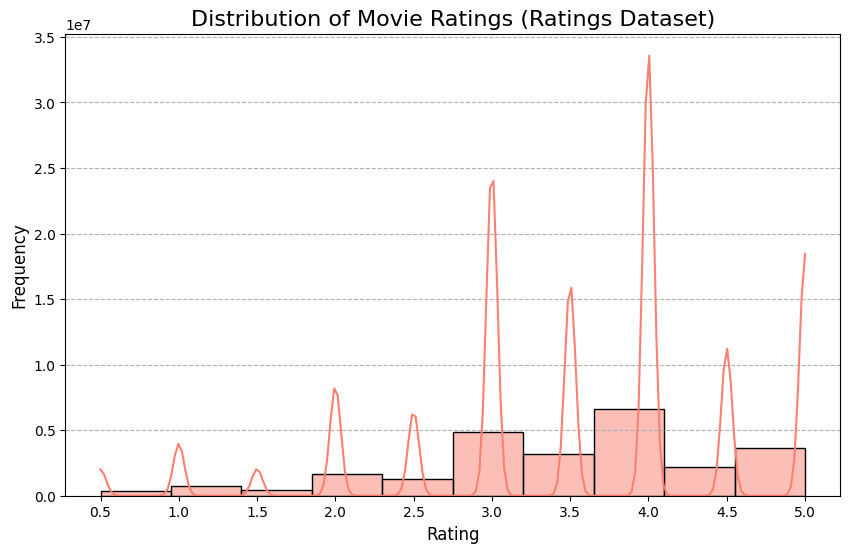

In [ ]:
# Analisis Univariat untuk Distribusi Nilai Rating (menggunakan histogram)

plt.figure(figsize=(10, 6))
sns.histplot(data=rating, x='rating', bins=10, kde=True, color='salmon')
plt.title('Distribution of Movie Ratings (Ratings Dataset)', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(np.arange(0.5, 5.5, 0.5)) # Menetapkan ticks pada nilai rating yang mungkin
plt.grid(axis='y', linestyle='--')
plt.show()

Analisis:


Dari grafik, kita dapat mengamati hal-hal berikut:

  - Puncak yang Jelas pada Rating Bulat dan Setengah: Kurva merah menunjukkan puncak frekuensi yang sangat tajam pada nilai rating bulat (misalnya, 3.0, 4.0, 5.0) dan nilai rating setengah (misalnya, 3.5, 4.5). Ini menunjukkan bahwa pengguna cenderung memberikan rating pada skala yang jelas ini.

  - Rating 4.0 Paling Sering Diberikan: Puncak tertinggi pada kurva merah dan batang histogram terbesar berada di sekitar rating 4.0, dengan frekuensi mendekati 3.5×107 (35 juta). Ini berarti rating 4.0 adalah yang paling populer dalam dataset ini.

  - Rating 3.0 dan 5.0 Juga Sangat Populer: Rating 3.0 menunjukkan puncak frekuensi yang signifikan (sekitar 2.4×107 atau 24 juta), dan rating 5.0 juga memiliki puncak yang tinggi (sekitar 1.8×107 atau 18 juta).

  - Rating Setengah Juga Sering Digunakan: Meskipun tidak setinggi rating bulat, rating 3.5 dan 4.5 juga memiliki puncak yang menonjol (sekitar 1.5×107 dan 1.1×107 masing-masing), menunjukkan bahwa pengguna sering menggunakan skala setengah poin.

  - Rating Rendah Kurang Sering Diberikan: Frekuensi rating yang lebih rendah (di bawah 3.0) jauh lebih kecil. Ada puncak-puncak kecil di 0.5, 1.0, 1.5, 2.0, dan 2.5, tetapi frekuensinya secara signifikan lebih rendah dibandingkan dengan rating yang lebih tinggi. Puncak terkecil ada di 0.5 dan 1.5.

  - Distribusi Tidak Normal: Distribusi rating ini jelas tidak mengikuti distribusi normal (bell curve). Sebaliknya, ini adalah distribusi multimodal dengan beberapa puncak yang berbeda, yang merupakan karakteristik umum dari data rating diskrit atau semi-diskrit di mana pengguna memiliki preferensi untuk nilai-nilai tertentu.

Insight:

  - Preferensi Skala Jelas: Pengguna cenderung memberikan rating pada poin-poin yang mudah dikenali pada skala (misalnya, 1, 2, 3, 4, 5 atau 0.5, 1.5, 2.5, 3.5, 4.5), daripada nilai-nilai di antaranya. Ini adalah perilaku umum dalam sistem rating bintang.

  - Kepuasan Pengguna Cenderung Positif: Mayoritas rating yang diberikan condong ke sisi positif dari skala (3.0 ke atas). Ini menunjukkan bahwa secara keseluruhan, item (film) dalam dataset ini cenderung diterima dengan baik oleh audiensnya.

  - Tantangan untuk Membedakan Kualitas Menengah: Karena banyak rating mengelompok pada nilai-nilai tertentu, mungkin sulit untuk membedakan nuansa kualitas antara film-film yang semuanya menerima rating "sangat bagus" (misalnya, banyak film akan mendapatkan 4.0 atau 3.5).

  - Pengaruh "Pembulatan" Rating: Puncak-puncak tajam menunjukkan bahwa pengguna cenderung "membulatkan" rating mereka ke nilai terdekat yang mereka rasa paling cocok, daripada menggunakan setiap kemungkinan nilai desimal. Ini adalah fenomena umum di banyak platform ulasan.

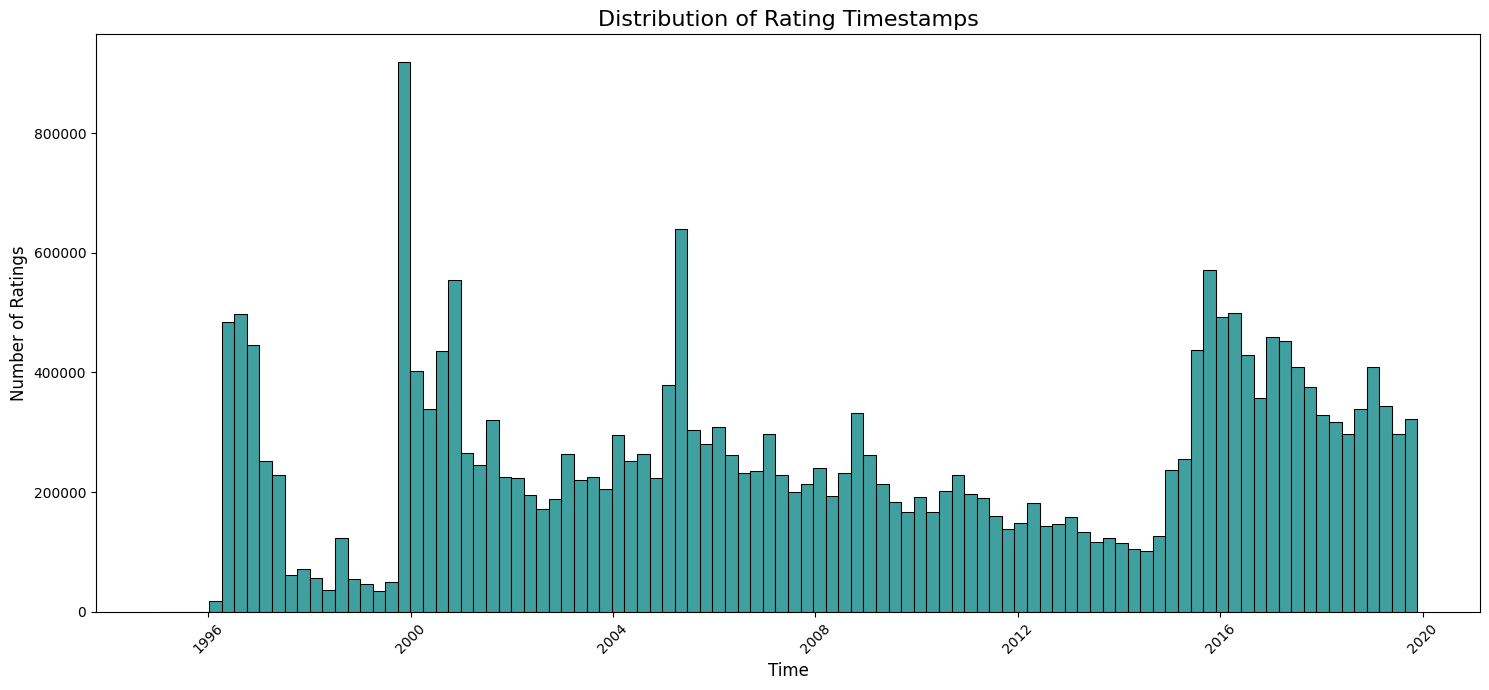


Rentang waktu rating:
Rating paling awal: 1995-01-09 11:46:49
Rating paling akhir: 2019-11-21 09:15:03


In [ ]:
# Analisis Univariat untuk Distribusi Timestamp (Waktu Rating Diberikan)

# Konversi timestamp ke datetime
rating['timestamp_dt'] = pd.to_datetime(rating['timestamp'], unit='s')

# Visualisasi distribusi rating sepanjang waktu
plt.figure(figsize=(15, 7))
sns.histplot(data=rating, x='timestamp_dt', bins=100, kde=False, color='teal') # Gunakan bins lebih banyak untuk detail waktu
plt.title('Distribution of Rating Timestamps', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Number of Ratings', fontsize=12)
plt.xticks(rotation=45) # Putar label sumbu x agar mudah dibaca
plt.tight_layout() # Sesuaikan layout
plt.show()

# Melihat rentang waktu rating
print("\nRentang waktu rating:")
print(f"Rating paling awal: {rating['timestamp_dt'].min()}")
print(f"Rating paling akhir: {rating['timestamp_dt'].max()}")

Analisis:

  - Awal Data (1995-1999): Dataset rating dimulai pada awal 1995 dengan jumlah rating yang relatif rendah. Ada peningkatan yang signifikan pada tahun 1996, mencapai sekitar 500.000 rating, kemudian menurun lagi.

  - Puncak Pertama (Sekitar Tahun 2000): Terjadi lonjakan besar dalam jumlah rating sekitar tahun 1999-2000, dengan puncaknya mencapai lebih dari 900.000 rating. Ini menunjukkan periode aktivitas rating yang sangat tinggi.

  - Periode Fluktuatif (2000-2015): Setelah puncak di tahun 2000, jumlah rating menunjukkan penurunan yang cukup signifikan dan fluktuatif, dengan beberapa puncak lebih kecil (misalnya, sekitar 2004 dan 2007) dan lembah-lembah. Tren umumnya menurun dari puncak tahun 2000 hingga sekitar tahun 2014-2015.

  - Puncak Kedua (Sekitar Tahun 2015-2016): Terjadi kenaikan tajam lagi dalam jumlah rating mulai sekitar tahun 2015, mencapai puncak kedua yang signifikan (sekitar 550.000-600.000 rating) di tahun 2015-2016. Ini menandai kebangkitan aktivitas rating.

  - Penurunan Menuju Akhir Data (2016-2019): Setelah puncak kedua, jumlah rating kembali menunjukkan tren penurunan hingga akhir data pada tahun 2019.

Insight:

  - Daur Hidup Platform/Dataset: Pola fluktuasi ini sangat mungkin mencerminkan daur hidup platform atau situs web tempat rating ini dikumpulkan. Puncak di tahun 2000 bisa jadi karena popularitas awal platform, kampanye promosi, atau periode di mana platform tersebut menjadi sangat dominan. Penurunan setelahnya bisa jadi karena munculnya pesaing, perubahan preferensi pengguna, atau perubahan internal pada platform.

  - Perubahan Perilaku Pengguna: Lonjakan kedua di tahun 2015-2016 bisa menunjukkan kebangkitan minat, mungkin karena fitur baru, peluncuran ulang platform, atau perubahan signifikan dalam cara orang berinteraksi dengan konten online dan memberikan ulasan/rating. Penurunan setelah itu mungkin karena kejenuhan pasar atau pergeseran ke platform lain.

  - Dampak Tren Teknologi/Internet: Puncak di awal tahun 2000-an dan pertengahan 2010-an juga bisa berkorelasi dengan era-era tertentu dalam perkembangan internet dan media digital. Misalnya, pertumbuhan internet di awal 2000-an dan kemudian popularitas media sosial/platform streaming di pertengahan 2010-an.

  - Kualitas dan Relevansi Data: Jika data ini digunakan untuk membangun sistem rekomendasi, penting untuk mempertimbangkan relevansi rating lama. Rating dari tahun 2000 mungkin tidak seakurat atau se-relevan rating dari tahun 2018 dalam memprediksi preferensi pengguna saat ini, terutama jika selera film atau tren media telah berubah.

  - Aktivitas Pengguna: Grafik ini adalah indikator langsung dari aktivitas pengguna dalam memberikan rating dari waktu ke waktu. Fluktuasi besar menunjukkan bahwa volume interaksi pengguna tidak konstan.

Secara keseluruhan, distribusi stempel waktu ini memberikan gambaran dinamis tentang bagaimana aktivitas pemberian rating telah berubah selama lebih dari dua dekade, yang kemungkinan besar dipengaruhi oleh faktor-faktor seperti evolusi platform, tren teknologi, dan perilaku pengguna.

### Bivariate Analysis

In [ ]:
# Gabungkan dataset movies dan ratings
# Gunakan inner join agar hanya film yang memiliki rating dan rating yang memiliki film yang disertakan
merged_data = pd.merge(rating, movies, on='movieId', how='inner')

print("Data gabungan (beberapa baris pertama):")
print(merged_data.head())
print("\nInfo Data Gabungan:")
merged_data.info()

Data gabungan (beberapa baris pertama):
   userId  movieId  rating   timestamp        timestamp_dt  \
0       1      296     5.0  1147880044 2006-05-17 15:34:04   
1       1      306     3.5  1147868817 2006-05-17 12:26:57   
2       1      307     5.0  1147868828 2006-05-17 12:27:08   
3       1      665     5.0  1147878820 2006-05-17 15:13:40   
4       1      899     3.5  1147868510 2006-05-17 12:21:50   

                                              title  \
0                               Pulp Fiction (1994)   
1  Three Colors: Red (Trois couleurs: Rouge) (1994)   
2  Three Colors: Blue (Trois couleurs: Bleu) (1993)   
3                                Underground (1995)   
4                        Singin' in the Rain (1952)   

                        genres    year  
0  Comedy|Crime|Drama|Thriller  1994.0  
1                        Drama  1994.0  
2                        Drama  1993.0  
3             Comedy|Drama|War  1995.0  
4       Comedy|Musical|Romance  1952.0  

Info Data

Menggabungkan dataset dengan inner join agar film yang memiliki rating dan rating yang memiliki film yang disertakan

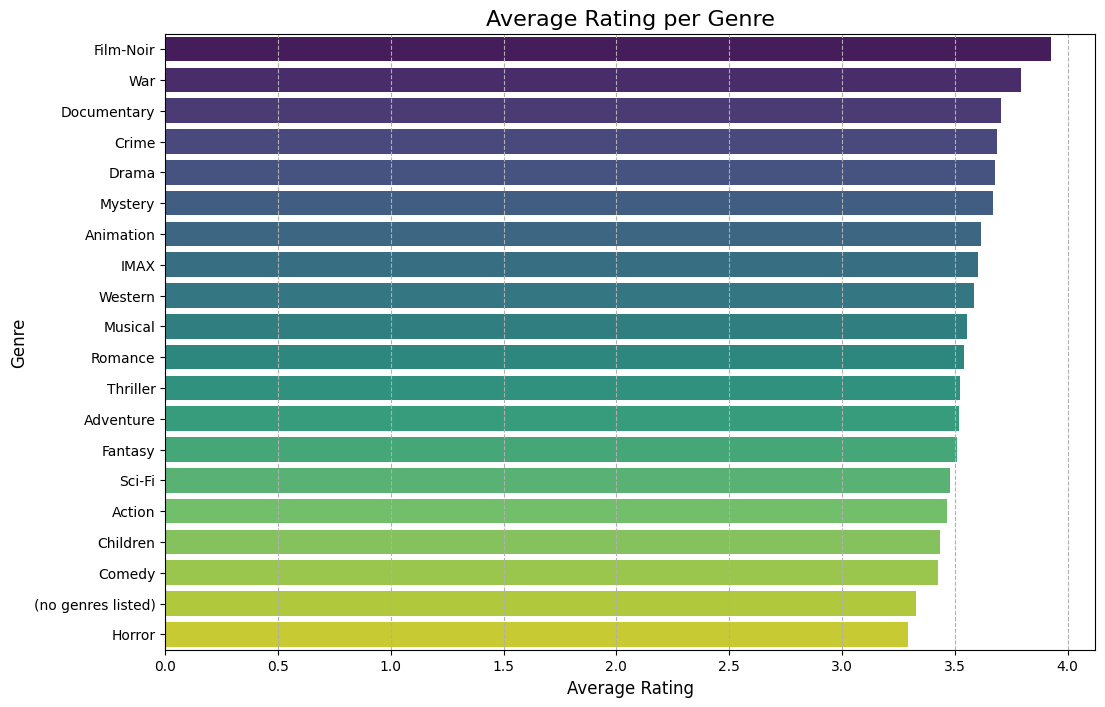

In [ ]:
# Hitung rating rata-rata per genre
# pisahkan genre dan gabungkan dengan rating
genre_ratings = merged_data.assign(genres=merged_data['genres'].str.split('|')).explode('genres')
average_rating_per_genre = genre_ratings.groupby('genres')['rating'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 8))
sns.barplot(x=average_rating_per_genre.values, y=average_rating_per_genre.index, palette='viridis')
plt.title('Average Rating per Genre', fontsize=16)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Genre', fontsize=12)
plt.grid(axis='x', linestyle='--')
plt.show()

Analisis:

  - Genre dengan Rating Rata-rata Tertinggi:
      - Film-Noir memiliki rating rata-rata tertinggi, mendekati 4.0.
        War juga memiliki rating rata-rata yang sangat tinggi, sedikit di bawah Film-Noir.
      - Documentary, Crime, Drama, dan Mystery menyusul di belakang, semuanya memiliki rating rata-rata di atas 3.5.

  - Genre dengan Rating Rata-rata Menengah:
      - Genre-genre seperti Animation, IMAX, Western, Musical, Romance, Thriller, Adventure, Fantasy, Sci-Fi, dan Action memiliki rating rata-rata di kisaran 3.3 hingga 3.6. Ini menunjukkan bahwa film-film dalam genre ini umumnya diterima dengan baik, tetapi tidak seistimewa genre teratas.

  - Genre dengan Rating Rata-rata Terendah:
      - Children, Comedy, dan "(no genres listed)" memiliki rating rata-rata yang lebih rendah, di kisaran 3.2 hingga 3.4.
      - Horror berada di posisi paling bawah dengan rating rata-rata terendah, sekitar 3.25.

  - Rentang Rating Rata-rata yang Relatif Sempit: Meskipun ada perbedaan, rentang rating rata-rata secara keseluruhan tidak terlalu lebar, yaitu dari sekitar 3.25 (Horror) hingga hampir 4.0 (Film-Noir). Ini menunjukkan bahwa sebagian besar genre memiliki kualitas rata-rata yang cukup baik dalam dataset ini.

Insight:

  - Kualitas yang Dirasakan vs. Popularitas: Menariknya, genre "Drama" yang merupakan genre paling sering muncul (berdasarkan grafik sebelumnya) memiliki rata-rata rating yang tinggi (di atas 3.5), menunjukkan bahwa popularitasnya juga diimbangi dengan penerimaan yang baik. Namun, genre yang paling populer kedua, "Comedy," justru berada di antara genre dengan rating rata-rata terendah. Ini mengisyaratkan bahwa film komedi mungkin diproduksi dalam jumlah besar, tetapi tidak selalu mendapatkan apresiasi rating setinggi genre lain.

  - Apresiasi untuk Genre Niche/Klasik: Genre seperti Film-Noir dan War, yang mungkin tidak diproduksi sebanyak genre populer lainnya, menunjukkan rating rata-rata yang sangat tinggi. Ini bisa berarti bahwa film-film dalam genre ini seringkali dianggap sebagai "karya klasik" atau menarik bagi audiens yang sangat menghargai kualitas tertentu.

  - Harapan Audiens: Rating rata-rata yang rendah untuk Horror dapat menunjukkan bahwa genre ini, meskipun memiliki penggemarnya, mungkin lebih sulit untuk memenuhi harapan audiens atau mungkin memiliki variasi kualitas yang lebih besar. Atau, sifat genre horor itu sendiri (menakutkan, mengganggu) mungkin memicu rating yang lebih terpolarisasi.

  - Implikasi untuk Produser/Distributor: Jika dataset ini merepresentasikan preferensi publik secara luas, produser mungkin akan lebih aman berinvestasi pada genre Drama, Crime, atau Documentary yang memiliki peluang tinggi untuk diterima dengan baik. Sementara itu, untuk genre seperti Comedy atau Horror, meskipun popular, mungkin diperlukan strategi yang lebih kuat untuk memastikan kualitas dan kepuasan penonton.

  - Kategori "(no genres listed)": Fakta bahwa kategori "(no genres listed)" memiliki rating rata-rata yang rendah (mirip dengan Children dan Comedy) bisa menunjukkan bahwa film-film tanpa klasifikasi genre yang jelas cenderung kurang mendapatkan apresiasi. Ini mungkin karena kesulitan dalam menemukan audiens target atau indikasi kualitas yang kurang terdefinisi.

Secara keseluruhan, grafik ini memberikan pemahaman tentang bagaimana berbagai genre film dipersepsikan dalam hal kualitas (berdasarkan rating rata-rata) dan dapat menjadi panduan berharga bagi pembuat film, kritikus, dan bahkan penonton.

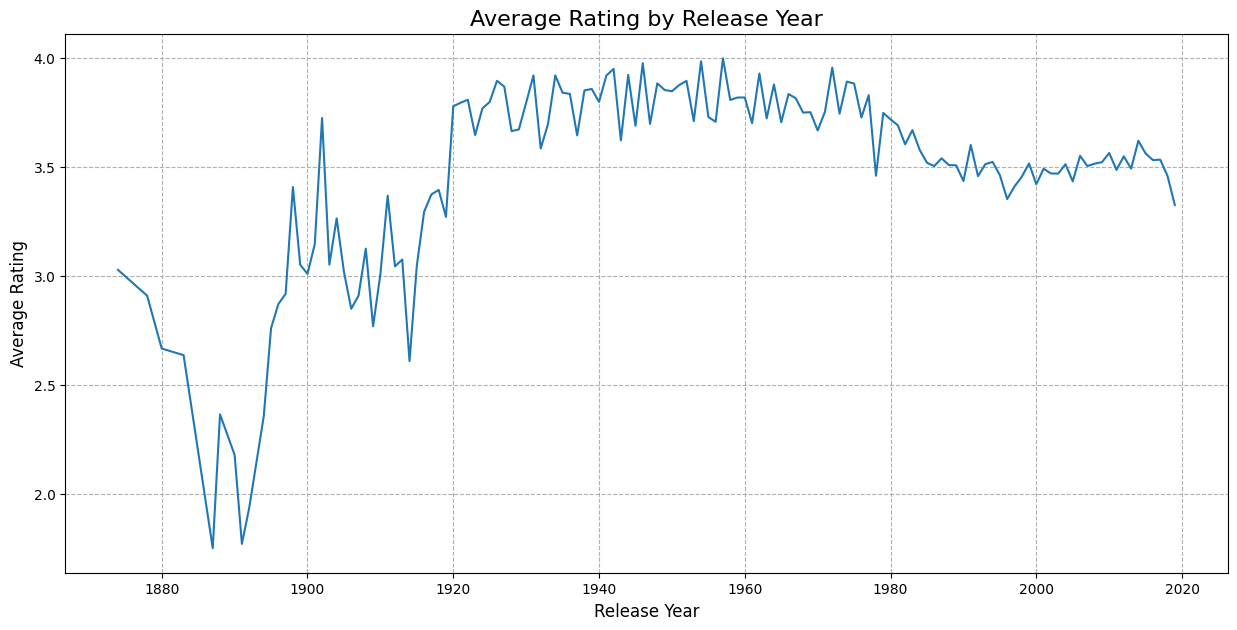

In [ ]:
# Hitung rating rata-rata per tahun rilis
# Pastikan kolom 'year' ada di merged_data (karena berasal dari movies)
average_rating_per_year = merged_data.groupby('year')['rating'].mean()
plt.figure(figsize=(15, 7))
sns.lineplot(x=average_rating_per_year.index, y=average_rating_per_year.values)
plt.title('Average Rating by Release Year', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(axis='both', linestyle='--')
plt.show()

Analisis:

  - Periode Awal (Pra-1920):
      - Pada awal sejarah perfilman (sekitar 1870-an hingga awal 1900-an), rating rata-rata film cenderung berfluktuasi dan relatif rendah, sering di bawah 3.0, bahkan turun mendekati 1.5-2.0 pada beberapa titik di akhir 1880-an.
      - Ada lonjakan sporadis, menunjukkan mungkin ada beberapa film awal yang sangat dihargai, tetapi secara keseluruhan kualitasnya bervariasi.

  - Peningkatan Tajam (Sekitar 1920-an):
      - Terjadi peningkatan drastis dalam rating rata-rata di sekitar tahun 1920-an. Dari sekitar 2.5-3.0, rating rata-rata melonjak cepat hingga di atas 3.5. Ini adalah periode transisi yang signifikan.

  - Era Keemasan/Stabilitas Tinggi (Sekitar 1925 - 1970-an):
      - Setelah peningkatan tajam, rata-rata rating film relatif stabil dan tinggi, sebagian besar berkisar antara 3.5 hingga 4.0. Ada fluktuasi kecil, tetapi secara umum ini menunjukkan periode di mana film-film secara konsisten mendapatkan rating yang tinggi. Ini sering disebut sebagai "Era Keemasan Hollywood" atau periode di mana film-film klasik diproduksi.Puncak sering mencapai atau bahkan sedikit melebihi 4.0.

  - Penurunan Bertahap (Sekitar 1970-an - Akhir 1990-an):
      - Mulai sekitar tahun 1970-an atau awal 1980-an, rata-rata rating mulai menunjukkan tren penurunan bertahap. Meskipun masih relatif tinggi, ada penurunan dari level di atas 3.5 menjadi di bawah 3.5 pada akhir 1990-an.

  - Stabilitas Modern (Akhir 1990-an - 2020):
      - Sejak sekitar akhir 1990-an hingga saat ini (sekitar 2020), rata-rata rating cenderung stabil kembali di sekitar 3.4 hingga 3.6. Ada fluktuasi, tetapi tidak ada penurunan tajam atau peningkatan signifikan seperti di awal abad ke-20.

Insight:

  - Evolusi Kualitas Film (Persepsi): Grafik ini dapat diinterpretasikan sebagai refleksi persepsi kualitas film dari waktu ke waktu.
      - Periode awal yang berfluktuasi menunjukkan eksperimentasi dan perkembangan format film.
      - Lonjakan di tahun 1920-an mungkin bertepatan dengan peningkatan artistik dan teknis dalam perfilman (misalnya, era film bersuara), yang meningkatkan daya tarik dan kualitas yang dirasakan.
      - Periode stabilitas tinggi di pertengahan abad ke-20 menunjukkan konsistensi dalam produksi film berkualitas tinggi atau terbentuknya standar perfilman.

  - Perubahan Perilaku Rating/Penonton: Penurunan bertahap setelah 1970-an hingga stabilisasi di era modern bisa disebabkan oleh beberapa faktor:
      - Peningkatan Volume Produksi: Seperti yang terlihat dari grafik distribusi tahun rilis sebelumnya, jumlah film yang diproduksi melonjak drastis di era modern. Semakin banyak film dirilis, semakin besar kemungkinan adanya variasi kualitas, yang bisa menurunkan rata-rata.
      - Perubahan Ekspektasi Penonton: Audiens mungkin menjadi lebih kritis seiring waktu, atau standar hiburan telah meningkat karena persaingan dari media lain.
      - Demokratisasi Rating: Dengan kemudahan akses untuk memberikan rating (melalui internet, aplikasi), lebih banyak orang dengan preferensi dan standar yang beragam dapat berpartisipasi, yang bisa meratakan atau sedikit menurunkan rata-rata dibandingkan era ketika rating mungkin lebih didominasi oleh kritikus atau penggemar yang sangat berdedikasi.

  - Dampak Nostalgia/Kanon: Film-film yang dirilis di era "emas" (sekitar 1925-1970) mungkin mendapatkan rating lebih tinggi saat ini karena status "klasik" atau "masterpiece" yang disandang sebagian di antaranya, serta kecenderungan nostalgia. Film-film lama yang buruk mungkin tidak banyak dinilai atau bahkan dilupakan, meninggalkan rata-rata yang lebih tinggi untuk film-film yang bertahan dalam ingatan kolektif.

  - Tren Kualitas Saat Ini: Rata-rata rating yang stabil di era modern (sekitar 3.4-3.6) menunjukkan bahwa meskipun volume produksi tinggi, kualitas film secara umum tetap berada pada tingkat yang solid, tidak terlalu rendah tetapi juga jarang mencapai puncak "sempurna" seperti di era emas.

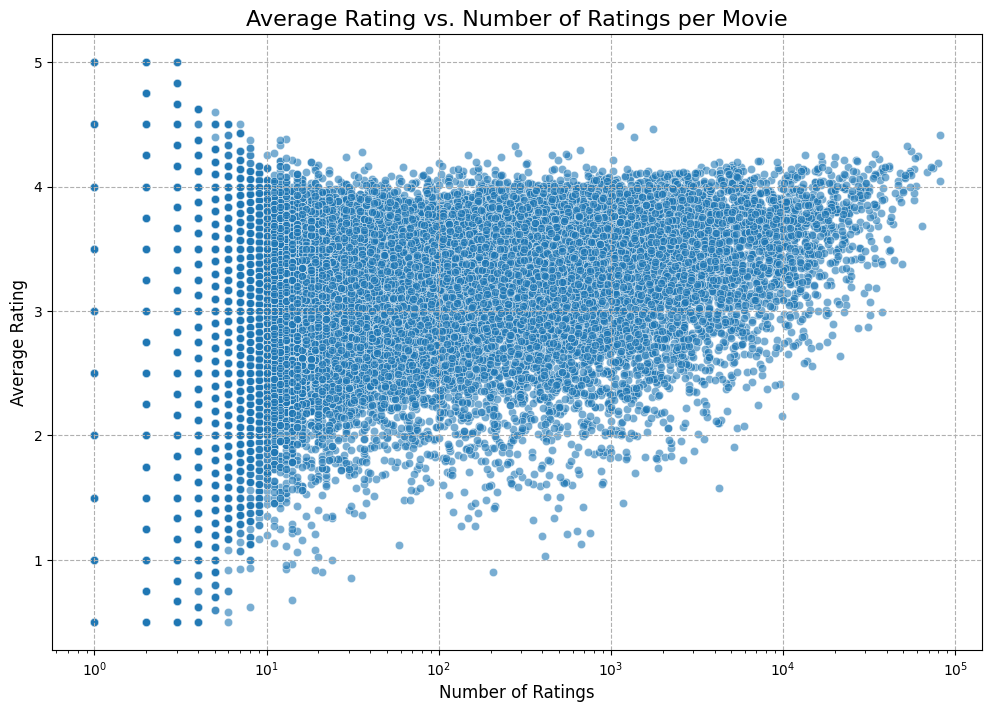

In [ ]:
# Hitung jumlah rating dan rating rata-rata per film
movie_stats = merged_data.groupby('movieId')['rating'].agg(['count', 'mean']).rename(columns={'count': 'rating_count', 'mean': 'average_rating'})
# Gabungkan kembali dengan data film untuk mendapatkan judul
movie_stats = pd.merge(movie_stats, movies[['movieId', 'title']], on='movieId', how='inner')
plt.figure(figsize=(12, 8))
sns.scatterplot(data=movie_stats, x='rating_count', y='average_rating', alpha=0.6)
plt.title('Average Rating vs. Number of Ratings per Movie', fontsize=16)
plt.xlabel('Number of Ratings', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xscale('log') # Gunakan skala log untuk sumbu x karena distribusi jumlah rating sangat miring
plt.grid(axis='both', linestyle='--')
plt.show()

Analisis:

  - Konsentrasi Rating pada Jumlah Rating Rendah:
    - Pada sisi kiri grafik (jumlah rating yang sangat rendah, terutama di bawah 10 rating), titik-titik (film) terlihat sangat padat dan tersebar secara vertikal di seluruh rentang rating. Ini menunjukkan bahwa film dengan sedikit rating dapat memiliki rata-rata rating dari yang sangat rendah (0.5) hingga sangat tinggi (5.0).
    - Ini adalah hal yang wajar: sebuah film yang hanya memiliki 1 atau 2 rating bisa dengan mudah mendapatkan rating rata-rata 5.0 (jika kedua rating adalah 5) atau 0.5 (jika ratingnya 0.5).

  - Penyempitan Rentang Rating Seiring Bertambahnya Jumlah Rating:
      - Seiring dengan meningkatnya "Number of Ratings" (bergerak ke kanan pada sumbu X), penyebaran vertikal rating rata-rata mulai menyempit.
      - Film dengan jumlah rating yang sangat tinggi (misalnya, 10^3 atau 10^4 ke atas) cenderung memiliki rata-rata rating yang terkonsentrasi di sekitar nilai tengah hingga tinggi (sekitar 3.0 hingga 4.5). Sangat jarang menemukan film dengan jumlah rating yang sangat banyak tetapi rata-rata ratingnya sangat rendah (< 2.0).
      - Ini menunjukkan efek "hukum angka besar": semakin banyak rating yang diterima sebuah film, semakin representatif rating rata-ratanya terhadap konsensus umum, dan ekstremitas (rating sangat tinggi atau sangat rendah) menjadi lebih sulit dipertahankan.

  - Korelasi Positif yang Lemah:
      - Ada sedikit kecenderungan positif secara keseluruhan; film dengan jumlah rating yang lebih banyak cenderung memiliki rata-rata rating yang sedikit lebih tinggi. Namun, ini bukan korelasi yang kuat dan banyak film dengan jumlah rating menengah masih memiliki rating rata-rata yang bervariasi.

  - Bentuk Kerucut/Corong:
      - Grafik ini memiliki bentuk seperti kerucut atau corong yang terbuka ke kiri (jumlah rating rendah) dan menyempit ke kanan (jumlah rating tinggi). Ini adalah pola yang sangat umum dalam analisis data rating.

Insight:

  - Keandalan Rating: Jumlah rating yang diterima oleh sebuah film adalah indikator penting dari keandalan rata-rata ratingnya.
      - Rating film dengan sedikit ulasan (cold start problem): Film dengan hanya beberapa rating tidak bisa diandalkan untuk menilai kualitasnya karena ratingnya sangat volatil. Sistem rekomendasi harus berhati-hati saat merekomendasikan film ini.
      - Rating film dengan banyak ulasan: Film dengan ribuan atau puluhan ribu rating cenderung memiliki rata-rata rating yang lebih stabil dan lebih mencerminkan kualitas yang disepakati oleh audiens luas.

  - Filter untuk Kualitas: Jika ingin menemukan film "berkualitas tinggi", sebaiknya tidak hanya mencari film dengan rating rata-rata 5.0, tetapi juga mempertimbangkan jumlah rating yang mendukung rata-rata tersebut. Film dengan rating 4.0 dan 10.000 rating kemungkinan besar "lebih baik" secara objektif daripada film dengan rating 5.0 dan hanya 5 rating.

  - Popularitas vs. Kualitas: Film dengan jumlah rating yang sangat tinggi seringkali adalah film-film yang sangat populer. Fakta bahwa film-film ini cenderung memiliki rata-rata rating di atas 3.0-3.5 menunjukkan bahwa popularitas sering kali berkorelasi dengan setidaknya tingkat kualitas yang baik, bukan hanya sekadar hype.

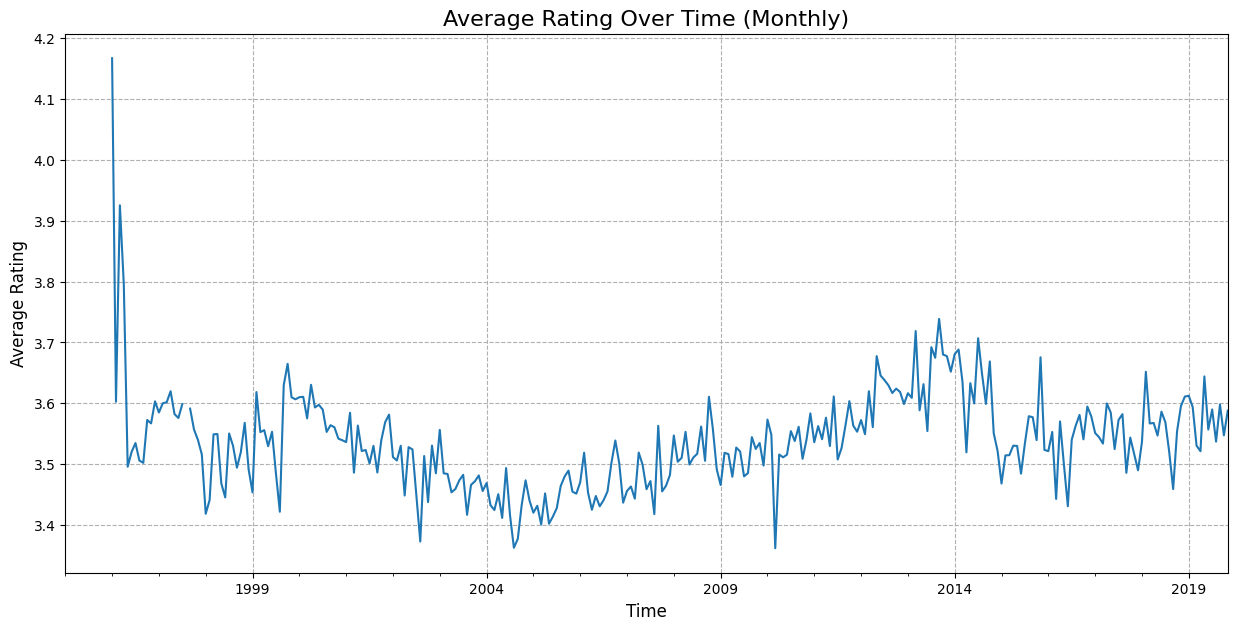

In [ ]:
# Hitung rating rata-rata per periode waktu (misalnya, per bulan atau per tahun)
# Kita bisa resample data berdasarkan timestamp
# Pastikan kolom 'timestamp_dt' ada di merged_data (karena berasal dari ratings)
merged_data['timestamp_dt'] = pd.to_datetime(merged_data['timestamp'], unit='s') # Pastikan kolom ini ada
# Agregasi rating rata-rata per bulan
average_rating_monthly = merged_data.set_index('timestamp_dt')['rating'].resample('M').mean()
plt.figure(figsize=(15, 7))
average_rating_monthly.plot()
plt.title('Average Rating Over Time (Monthly)', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.grid(axis='both', linestyle='--')
plt.show()

Analisis:

  - Volatilitas Tinggi di Awal Periode (Akhir 1996 - Awal 1997):
      - Pada awal grafik, terlihat fluktuasi yang sangat besar dan tajam. Ada lonjakan rating rata-rata yang sangat tinggi, mencapai puncaknya di atas 4.1, diikuti oleh penurunan drastis.
      - Volatilitas ini kemungkinan besar disebabkan oleh jumlah rating yang sangat sedikit pada bulan-bulan awal platform atau dataset, sehingga satu atau dua rating tinggi/rendah dapat sangat mempengaruhi rata-rata.

  - Periode Penurunan Bertahap (Sekitar 1997 - 2004):
      - Setelah volatilitas awal, rata-rata rating menunjukkan tren penurunan umum dari sekitar 3.6-3.7 pada tahun 1997-1998 menjadi di bawah 3.4 pada tahun 2004. Meskipun ada fluktuasi bulanan, tren jangka panjangnya adalah menurun.

  - Periode Peningkatan Bertahap (Sekitar 2004 - 2014):
      - Mulai sekitar tahun 2004, tren mulai berbalik. Rata-rata rating mulai menunjukkan peningkatan yang konsisten, dari titik terendah di bawah 3.4 menjadi di atas 3.7 pada tahun 2014. Ini adalah periode pemulihan dan peningkatan kualitas rata-rata yang dirasakan.

  - Fluktuasi Menurun (Sekitar 2014 - 2019):
      - Setelah mencapai puncaknya sekitar tahun 2014, rata-rata rating kembali menunjukkan sedikit tren penurunan atau stabilisasi dengan fluktuasi yang cukup signifikan, kembali ke kisaran 3.5-3.6 pada akhir data di tahun 2019.

  - Fluktuasi Bulanan yang Konsisten: Di seluruh grafik (setelah volatilitas awal), terlihat adanya fluktuasi bulanan yang cukup reguler. Ini mungkin disebabkan oleh faktor musiman (misalnya, film-film yang dirilis pada musim tertentu atau kebiasaan rating pengguna).

Insight:

  - Daur Hidup Kualitas Konten/Platform: Perubahan tren rata-rata rating ini bisa mencerminkan evolusi kualitas film yang dirilis dari waktu ke waktu, atau evolusi perilaku pengguna dalam memberikan rating pada platform tersebut.
      - Penurunan di awal mungkin menunjukkan bahwa seiring bertambahnya jumlah pengguna dan konten, rating menjadi lebih beragam dan tidak lagi didominasi oleh "film-film favorit" awal.
      - Peningkatan di pertengahan 2000-an bisa jadi merupakan periode di mana film-film secara umum dipandang lebih baik, atau standar penilaian pengguna sedikit melunak, atau platform berhasil menarik pengguna yang cenderung memberikan rating lebih tinggi.

  - Pengaruh Jumlah Rating per Bulan: Volatilitas yang tinggi di awal adalah indikasi bahwa jumlah rating per bulan masih sangat kecil. Seiring berjalannya waktu, jumlah rating per bulan meningkat (seperti yang terlihat pada grafik distribusi timestamp sebelumnya), yang membuat rata-rata rating menjadi lebih stabil dan representatif, meskipun masih menunjukkan tren.

  - Musiman/Tren Pasar: Fluktuasi bulanan dapat mengisyaratkan adanya musim-musim tertentu di mana film-film berkualitas tinggi dirilis (misalnya, musim penghargaan di akhir tahun) atau periode di mana pengguna lebih aktif memberikan rating.

  - Kualitas Terukur dari Waktu ke Waktu: Meskipun rata-rata rating tidak pernah mencapai level ekstrim seperti di awal data, ada tren jangka panjang yang menunjukkan naik turunnya persepsi kualitas film secara kolektif dari tahun ke tahun.

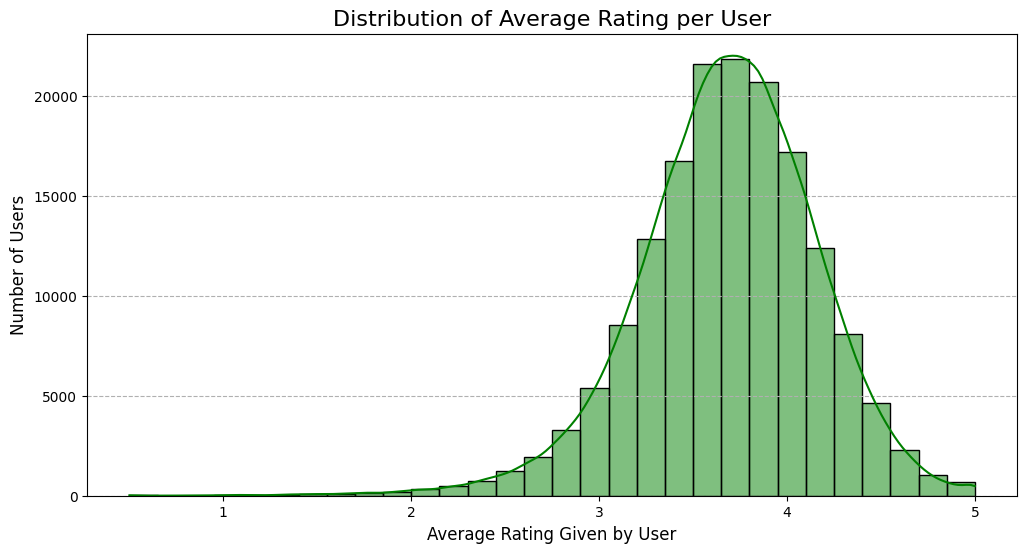

In [ ]:
# Hitung rating rata-rata per pengguna
average_rating_per_user = rating.groupby('userId')['rating'].mean()
plt.figure(figsize=(12, 6))
sns.histplot(average_rating_per_user, bins=30, kde=True, color='green')
plt.title('Distribution of Average Rating per User', fontsize=16)
plt.xlabel('Average Rating Given by User', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)
plt.grid(axis='y', linestyle='--')
plt.show()

Analisis:

  - Distribusi Mirip Kurva Bell (Skewed): Histogram ini menunjukkan distribusi yang kurang lebih berbentuk kurva bell (mirip distribusi normal), tetapi sedikit miring (skewed) ke kiri, atau lebih tepatnya, memiliki ekor yang lebih panjang di sisi kiri (rating rendah). Ini menunjukkan bahwa sebagian besar pengguna cenderung memberikan rating rata-rata yang cukup tinggi.

  - Puncak Konsentrasi (Mode) di Sekitar 3.5 - 4.0:
      - Jumlah pengguna tertinggi (lebih dari 20.000) memiliki rata-rata rating di kisaran 3.5 hingga 4.0.
      - Puncak distribusi terlihat jelas di antara 3.5 dan 4.0, menunjukkan bahwa ini adalah rata-rata rating paling umum yang diberikan oleh pengguna.

  - Mayoritas Pengguna Memberikan Rating Positif:
      - Sebagian besar pengguna memiliki rata-rata rating di atas 3.0.
      - Semakin rendah rata-rata rating, semakin sedikit jumlah penggunanya. Sangat sedikit pengguna yang memiliki rata-rata rating di bawah 2.0. Ini berarti jarang ada pengguna yang secara konsisten memberikan rating yang sangat rendah.

  - Ekor Kiri yang Lebih Panjang: Ada sejumlah kecil pengguna yang memberikan rata-rata rating yang sangat rendah (mendekati 0-1), meskipun jumlahnya sangat kecil dibandingkan dengan pengguna yang memberikan rating lebih tinggi. Ini menunjukkan adanya "kritikus keras" atau pengguna yang sangat selektif.

  - Ekor Kanan yang Lebih Pendek: Jumlah pengguna yang memberikan rating rata-rata mendekati 5.0 (sempurna) juga ada, tetapi lebih sedikit dibandingkan dengan puncak, menunjukkan bahwa tidak banyak pengguna yang selalu memberikan rating sempurna.

Insight:

  - Pengguna Cenderung Bersikap Positif: Secara umum, pengguna dalam dataset ini cenderung memberikan rating yang positif. Ini bisa berarti bahwa item yang dinilai (misalnya, film) secara umum berkualitas baik, atau ada kecenderungan alami pengguna untuk tidak terlalu kritis atau memberikan rating yang lebih tinggi.

  - Identifikasi Jenis Pengguna:
      - Mayoritas (sekitar 3.5-4.0): Ini adalah pengguna "rata-rata" yang memberikan rating wajar, mungkin cenderung sedikit positif.
      - Kritikus Keras (rata-rata rendah): Kelompok kecil pengguna ini secara konsisten memberikan rating yang rendah, mungkin karena standar yang sangat tinggi atau memang tidak menyukai sebagian besar item yang dinilai.
      - "Fans" (rata-rata tinggi mendekati 5.0): Ada juga kelompok kecil pengguna yang secara konsisten memberikan rating sangat tinggi, mungkin karena mereka hanya menilai film yang sangat mereka sukai atau memiliki toleransi yang tinggi.

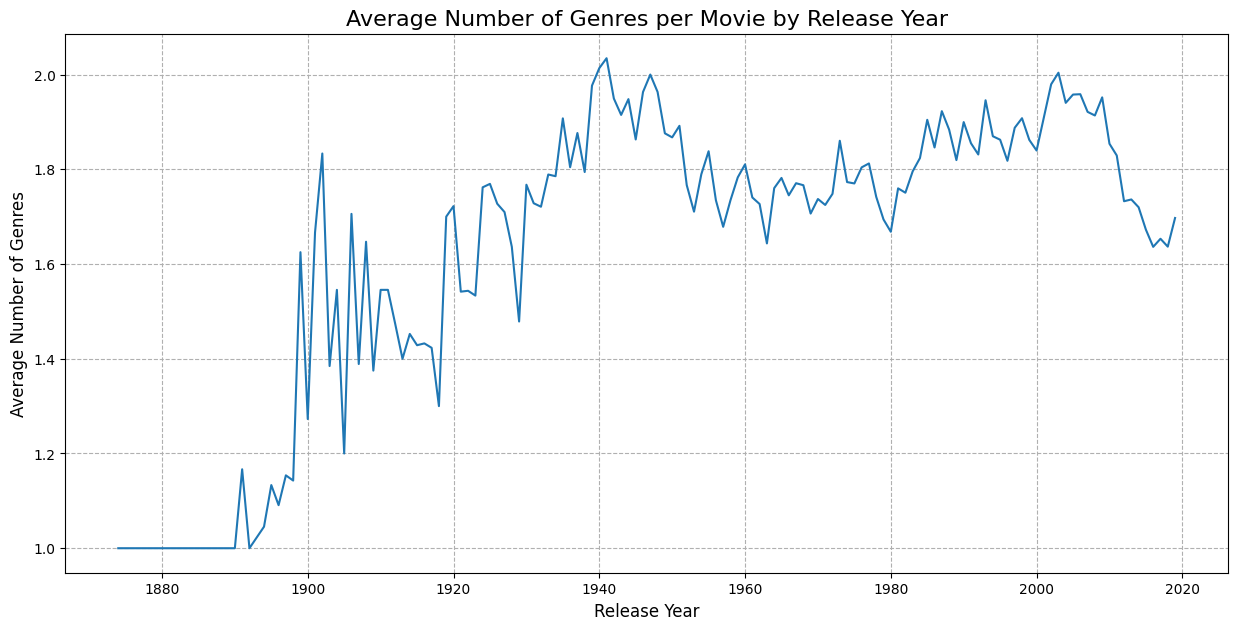

In [ ]:
# Hitung jumlah genre per film
movies['genre_count'] = movies['genres'].apply(lambda x: len(x.split('|')) if x else 0)
# Hitung rata-rata jumlah genre per tahun rilis
average_genre_count_per_year = movies.groupby('year')['genre_count'].mean()
plt.figure(figsize=(15, 7))
sns.lineplot(x=average_genre_count_per_year.index, y=average_genre_count_per_year.values)
plt.title('Average Number of Genres per Movie by Release Year', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Average Number of Genres', fontsize=12)
plt.grid(axis='both', linestyle='--')
plt.show()

Analisis:

  - Periode Awal (Pra-1900): Pada awal dataset, rata-rata jumlah genre per film adalah 1.0. Ini berarti film-film yang sangat awal kemungkinan besar hanya diberi satu genre saja, atau mungkin kategorisasi genre belum sekompleks sekarang.

  - Peningkatan Volatilitas (Sekitar 1900 - 1920):
      - Sekitar awal abad ke-20, grafik menunjukkan peningkatan yang signifikan dan sangat fluktuatif dalam rata-rata jumlah genre. Ada lonjakan tajam hingga di atas 1.8, diikuti oleh penurunan, dan kemudian naik turun lagi.
      - Volatilitas tinggi di periode ini bisa jadi karena jumlah film yang sedikit per tahun, atau sistem kategorisasi genre yang belum matang atau konsisten pada masa itu.

  - Tren Kenaikan dan Puncak (Sekitar 1920 - 1940-an):
      - Setelah tahun 1920-an, ada tren kenaikan yang lebih stabil dalam rata-rata jumlah genre.
      - Puncak tertinggi terjadi sekitar akhir 1930-an hingga awal 1940-an, di mana rata-rata jumlah genre per film mencapai lebih dari 2.0 (yaitu, rata-rata setiap film memiliki dua genre atau lebih).

  - Periode Fluktuatif yang Menurun (1940-an - Awal 1990-an):
      - Setelah puncaknya di era 1940-an, rata-rata jumlah genre per film menunjukkan tren penurunan umum, meskipun dengan fluktuasi yang signifikan. Rata-rata ini bergerak turun dari sekitar 2.0 menjadi sekitar 1.7-1.8.

  - Kenaikan dan Stabilisasi Kembali (Awal 1990-an - Awal 2000-an):
      - Sekitar awal 1990-an, rata-rata jumlah genre mulai menunjukkan tren kenaikan lagi, mencapai puncak lokal di awal 2000-an, kembali di atas 2.0.

  - Penurunan Akhir (Sekitar 2010 - 2020):
      - Setelah sekitar tahun 2010, ada tren penurunan yang cukup jelas dalam rata-rata jumlah genre per film, turun dari sekitar 2.0 menjadi sekitar 1.6-1.7 pada tahun 2020.

Insight:

  - Evolusi Kategorisasi Genre: Grafik ini menunjukkan evolusi bagaimana film dikategorikan atau seberapa kompleksitas genre film dari waktu ke waktu.
      - Awalnya, film mungkin sangat sederhana sehingga hanya butuh satu genre, atau definisi genre belum luas.
      - Peningkatan di awal abad ke-20 mungkin mencerminkan perkembangan narasi film yang lebih kompleks, yang membutuhkan lebih dari satu label genre.

  - Tren Hibridisasi Genre:
      - Puncak di era 1930-an/1940-an dan awal 2000-an mungkin mengindikasikan periode di mana film-film hibrida genre (misalnya, Action-Comedy, Sci-Fi Thriller) menjadi lebih umum atau lebih sering diklasifikasikan dengan multiple genre.
      - Penurunan di tahun-tahun terakhir (setelah 2010) bisa berarti ada pergeseran kembali ke film dengan genre yang lebih "murni" atau sistem klasifikasi genre yang lebih ketat, atau mungkin ada tren untuk membatasi jumlah tag genre yang diberikan.

### Multivariate Analysis

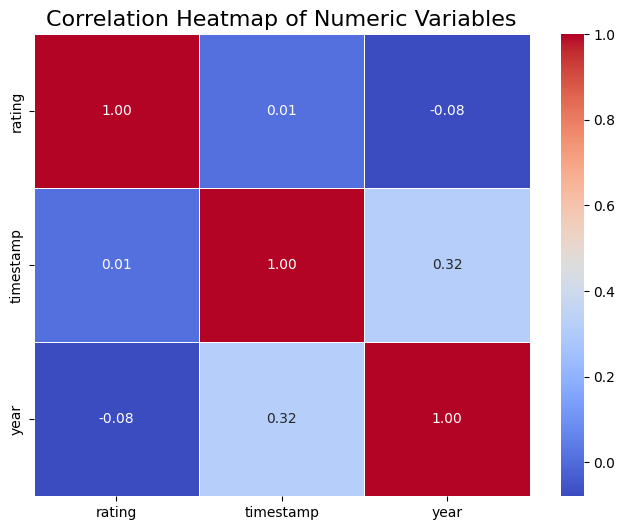

In [ ]:
numeric_cols = ['rating', 'timestamp', 'year'] # Pastikan 'year' ada dan numerik

# Hitung matriks korelasi Pearson
correlation_matrix = merged_data[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Numeric Variables', fontsize=16)
plt.show()

Analisis dan Insight:

  - Korelasi Diri (Diagonal):
      - rating dengan rating: 1.00
      - timestamp dengan timestamp: 1.00
      - year dengan year: 1.00
      
      
  Ini adalah hal yang wajar karena setiap variabel berkorelasi sempurna dengan dirinya sendiri.

  - Korelasi rating dengan Variabel Lain:
      - rating dengan timestamp: 0.01 (sangat mendekati nol).
      - rating dengan year: -0.08 (sangat mendekati nol, sedikit negatif).
      - Insight: Ini menunjukkan bahwa rating film hampir tidak memiliki korelasi dengan timestamp (kapan rating diberikan) atau year (tahun rilis film). Artinya, seiring berjalannya waktu, rating rata-rata film (atau rating individual) tidak secara signifikan cenderung naik, turun, atau berubah secara linier. Ini penting karena:
          - Rating film lama tidak secara inheren lebih baik atau lebih buruk daripada film baru hanya karena usianya.
          - Perilaku pemberi rating tidak menunjukkan bias temporal yang kuat (yaitu, orang tidak tiba-tiba menjadi lebih pelit atau lebih murah hati dengan rating mereka seiring waktu).

  - Korelasi timestamp dengan Variabel Lain:
      - timestamp dengan rating: 0.01 (sudah dibahas).
      - timestamp dengan year: 0.32 (positif, moderat).
      - Insight: Ada korelasi positif moderat antara timestamp (kapan rating diberikan) dan year (tahun rilis film). Ini masuk akal karena:
          - Semakin baru tahun rilis film, semakin mungkin film tersebut dinilai pada timestamp yang lebih baru juga.
          - Orang cenderung menilai film yang baru dirilis atau film yang sedang populer saat ini. Ini juga bisa berarti bahwa pengguna cenderung memberikan rating secara aktif untuk film-film dari era mereka sendiri atau yang baru mereka tonton.

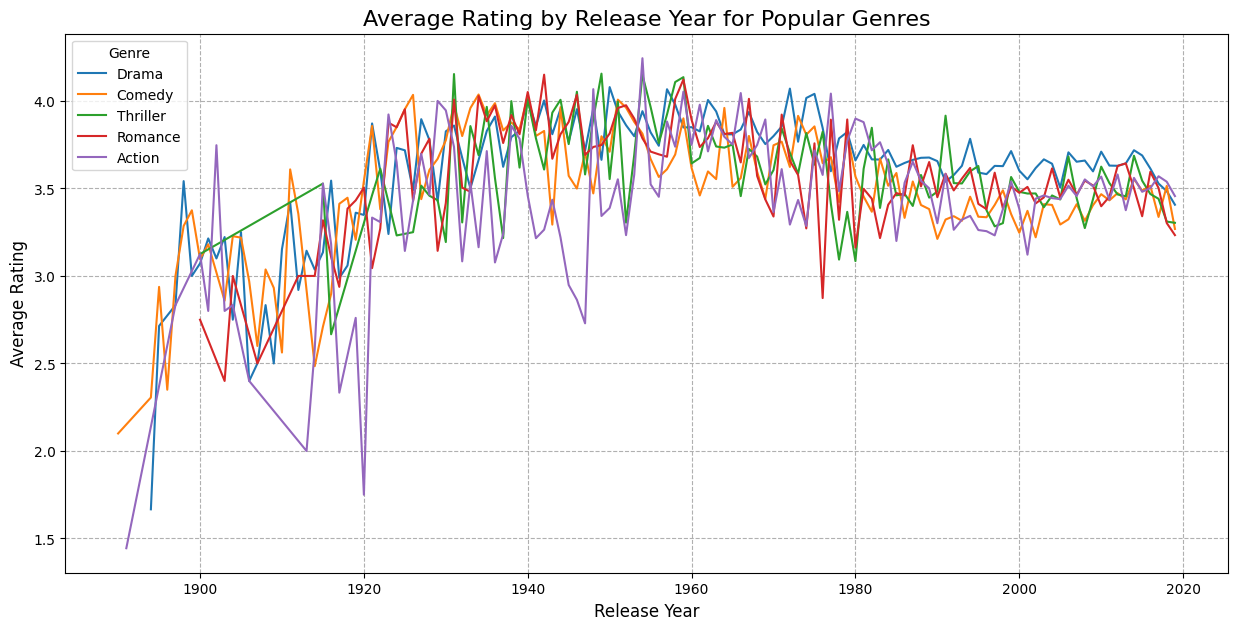

In [ ]:
# Contoh: Distribusi Rating untuk Genre Tertentu Berdasarkan Tahun Rilis
# Pilih beberapa genre populer untuk visualisasi
popular_genres = all_genres.value_counts().head(5).index.tolist()
# Filter data gabungan untuk genre-genre ini
filtered_data = merged_data[merged_data['genres'].str.contains('|'.join(popular_genres), na=False)]
plt.figure(figsize=(15, 7))
for genre in popular_genres:
    # Filter data untuk film dengan genre spesifik ini
    genre_data = merged_data[merged_data['genres'].str.contains(genre, na=False)]
    # Hitung rata-rata rating per tahun untuk genre ini
    avg_rating_genre_year = genre_data.groupby('year')['rating'].mean()
    sns.lineplot(x=avg_rating_genre_year.index, y=avg_rating_genre_year.values, label=genre)
plt.title('Average Rating by Release Year for Popular Genres', fontsize=16)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.legend(title='Genre')
plt.grid(axis='both', linestyle='--')
plt.show()

Insight:

  - Perbedaan Kualitas yang Dirasakan antar Genre: Meskipun semua genre mengalami pasang surut dalam rating rata-rata mereka sepanjang sejarah, ada perbedaan konsisten dalam bagaimana genre-genre tertentu dipersepsikan.
      - Drama seringkali mempertahankan rata-rata rating yang relatif tinggi, menunjukkan bahwa film-film drama sering diterima dengan baik oleh penonton.
      - Comedy secara konsisten terlihat di bagian bawah dari genre-genre populer ini, mengindikasikan bahwa meskipun film komedi mungkin populer dalam jumlah (seperti yang terlihat di grafik frekuensi genre sebelumnya), kualitas yang dirasakan (berdasarkan rating) tidak selalu setinggi genre lain. Mungkin standar humor sangat subjektif atau kualitas komedi sangat bervariasi.
      - Thriller menunjukkan fluktuasi, tetapi seringkali berada di tengah hingga atas, menunjukkan genre ini umumnya menghadirkan pengalaman yang memuaskan.

  - Dampak Tren Industri dan Preferensi Audiens: Perubahan rata-rata rating per genre dari waktu ke waktu mencerminkan bagaimana selera penonton berubah, bagaimana genre-genre berkembang, dan mungkin juga bagaimana kualitas produksi genre tertentu berfluktuasi.

  - Fokus pada Genre: Bagi pembuat film atau platform konten, analisis ini dapat membantu mengidentifikasi genre mana yang cenderung dihargai oleh penonton dari waktu ke waktu. Misalnya, jika ingin membuat film yang cenderung mendapatkan rating tinggi, drama atau thriller mungkin pilihan yang lebih "aman" dibandingkan komedi.

# Data Preparation

In [ ]:
#Load ulang dataset dan batasi di 15000
ratings = pd.read_csv('/home/crxtan/Downloads/Movie/ratings.csv')
ratings = ratings.head(15000)
print(f"Ratings DataFrame sekarang berisi {len(ratings)} records.")
movies = pd.read_csv('/home/crxtan/Downloads/Movie/movies.csv')
movies = movies.head(15000)
print(f"Movies DataFrame sekarang berisi {len(movies)} records.")

Ratings DataFrame sekarang berisi 15000 records.
Movies DataFrame sekarang berisi 15000 records.


Melakukan pemuatan ulang dataset karena pada saat EDA ada sedikit perubahan di dataframe untuk lebih mengenali pola pola yang ada dan membatasi hanya 15000 record untuk modeling nya

In [ ]:
# Content-Based Recommendation Data Preparation
# Fill empty genres with 'Unknown'
movies['genres'] = movies['genres'].fillna('Unknown')

# TF-IDF Vectorization
tfidf = TfidfVectorizer(token_pattern=r"[^|]+")
tfidf_matrix = tfidf.fit_transform(movies['genres'])

# Cosine similarity matrix for content-based recommendations
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Mapping movie titles to their indices for easy lookup
indices = pd.Series(movies.index, index=movies['title']).drop_duplicates()

Penjelasan Konsep TF-IDF:

TF-IDF adalah teknik statistik numerik yang digunakan untuk merefleksikan seberapa penting sebuah kata (atau dalam kasus ini, sebuah genre) dalam sebuah dokumen (dalam kasus ini, sebuah film) dalam sebuah korpus (kumpulan semua film).

  - TF (Term Frequency): Mengukur seberapa sering sebuah kata muncul dalam sebuah dokumen. Semakin sering muncul, semakin penting kata itu bagi dokumen tersebut.
  - TF(t,d)=Jumlah kemunculan t dalam d/Jumlah kata dalam d
    - Dalam konteks genre, jika sebuah film memiliki genre "Action|Comedy", maka TF untuk "Action" adalah 1 (karena muncul sekali dalam daftar genre film itu).

    - IDF (Inverse Document Frequency): Mengukur seberapa jarang sebuah kata muncul di seluruh korpus dokumen. Kata yang muncul di banyak dokumen dianggap kurang informatif atau kurang unik.
    - IDF(t,D)=log(Jumlah total dokumen/(1+Jumlah dokumen yang mengandung t))
    - (Penambahan 1 pada penyebut adalah untuk menghindari pembagian dengan nol jika kata tidak muncul di dokumen manapun).
    - Dalam konteks genre, genre yang sangat umum seperti "Drama" akan memiliki IDF yang rendah, sedangkan genre yang jarang seperti "Film-Noir" akan memiliki IDF yang tinggi.

    - TF-IDF: Hasil kali dari TF dan IDF. Skor TF-IDF yang tinggi berarti sebuah genre sering muncul dalam satu film tertentu (TF tinggi) dan jarang muncul di film lain secara keseluruhan (IDF tinggi). Ini membantu mengidentifikasi genre yang unik dan penting untuk film tersebut.

Bagaimana itu Bekerja dalam Kode:

  - TfidfVectorizer(token_pattern=r"[^|]+"): Ini adalah objek dari pustaka sklearn.feature_extraction.text.
      - token_pattern=r"[^|]+": Parameter ini sangat penting. Secara default, TfidfVectorizer akan memecah teks menjadi kata-kata menggunakan spasi. Namun, genre dalam dataset film seringkali dipisahkan oleh tanda | (pipa), misalnya "Action|Adventure|Sci-Fi". r"[^|]+" adalah regular expression yang memberi tahu vektorizer untuk menganggap setiap string yang tidak mengandung tanda pipa sebagai satu token (genre). Jadi, "Action", "Adventure", dan "Sci-Fi" akan menjadi token terpisah.
  - tfidf.fit_transform(movies['genres']):
      - fit: Mempelajari kosakata (daftar unik semua genre yang ada di dataset) dan menghitung nilai IDF untuk setiap genre.
      - transform: Mengubah setiap daftar genre film menjadi representasi numerik (vektor) berdasarkan skor TF-IDF untuk setiap genre yang ada di kosakata. Hasilnya adalah tfidf_matrix, yang merupakan matriks sparse (kebanyakan nilainya nol) di mana setiap baris mewakili satu film dan setiap kolom mewakili satu genre, dengan nilai sel adalah skor TF-IDF genre tersebut untuk film itu.

Penjelasan Konsep Cosine Similarity:

Cosine similarity adalah ukuran kemiripan antara dua vektor non-nol dari sebuah ruang produk dalam. Ini mengukur kosinus dari sudut antara dua vektor. Semakin kecil sudutnya, semakin tinggi kosinusnya, dan semakin besar kemiripan vektornya.

Rentang nilai cosine similarity adalah dari -1 hingga 1:

  - 1: Sangat mirip (arah vektor sama persis).
  - 0: Tidak ada kemiripan (vektor ortogonal, tidak ada hubungan).
  - -1: Sangat tidak mirip (arah vektor berlawanan).

Rumus Cosine Similarity antara dua vektor A dan B:
$\text{cosine_similarity}(A, B) = (A \cdot B) / (||A|| \cdot ||B||)$
Dimana:

  - A⋅B adalah dot product (produk titik) dari vektor A dan B.
  - ∣∣A∣∣ adalah magnitude (panjang) vektor A.
  - ∣∣B∣∣ adalah magnitude (panjang) vektor B.

Bagaimana itu Bekerja dalam Kode:

  - cosine_similarity(tfidf_matrix, tfidf_matrix): Fungsi ini menghitung kesamaan kosinus antara setiap pasangan vektor dalam tfidf_matrix.
  - Output: Hasilnya adalah matriks cosine_sim berukuran N×N (N adalah jumlah film), di mana setiap elemen cosine_sim[i][j] mewakili kesamaan kosinus antara film i dan film j berdasarkan representasi TF-IDF genre mereka.
  - Tujuan: Matriks ini adalah inti dari sistem rekomendasi berbasis konten saya. Jika dua film memiliki skor kesamaan kosinus yang tinggi (mendekati 1), berarti mereka memiliki profil genre yang sangat mirip. Film dengan profil genre yang mirip cenderung direkomendasikan kepada pengguna yang menyukai film tersebut.

Penjelasan indices: Baris kode ini membuat sebuah objek pandas.Series yang berfungsi sebagai "kamus" atau "peta" untuk mencari indeks internal (numerik) dari sebuah film berdasarkan judulnya.

Bagaimana itu Bekerja:

  - movies.index: Ini mengambil indeks asli dari DataFrame movies (misalnya, 0, 1, 2, ...).
  - index=movies['title']: Ini menetapkan kolom title dari DataFrame movies sebagai indeks dari Series yang baru dibuat.
  - pd.Series(...): Menggabungkan ini menjadi sebuah Series.
  - .drop_duplicates(): Jika ada dua film dengan judul yang persis sama, drop_duplicates() akan memastikan bahwa hanya satu entri (yang pertama kali muncul) yang dipertahankan. Ini mencegah ambiguasi saat mencari indeks berdasarkan judul.

Tujuan: Saat ingin mencari film yang mirip dengan film tertentu, saya akan memiliki judul filmnya. Dengan indices, bisa dengan cepat mendapatkan indeks numerik film tersebut di tfidf_matrix dan cosine_sim, yang kemudian memungkinkan untuk mencari film-film lain yang mirip.

  - Contoh Penggunaan: indices['Toy Story'] akan mengembalikan indeks numerik film 'Toy Story'.

In [ ]:
cosine_sim

array([[1.        , 0.79538991, 0.15315476, ..., 0.2514561 , 0.        ,
        0.        ],
       [0.79538991, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15315476, 0.        , 1.        , ..., 0.60907154, 0.        ,
        0.        ],
       ...,
       [0.2514561 , 0.        , 0.60907154, ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 1.        ,
        1.        ]])

Output dari cosine similarity berdasarkan penjelasan diatas

In [ ]:
# LabelEncoder transforms categorical IDs into numerical labels (0 to N-1),
# which are required for embedding layers.
user_enc = LabelEncoder()
movie_enc = LabelEncoder()

ratings['user'] = user_enc.fit_transform(ratings['userId'])
ratings['movie'] = movie_enc.fit_transform(ratings['movieId'])

# Get the number of unique users and movies for embedding layer dimensions
num_users = ratings['user'].nunique()
num_movies = ratings['movie'].nunique()

print(f"Number of unique users: {num_users}")
print(f"Number of unique movies: {num_movies}")

Number of unique users: 119
Number of unique movies: 4047


Penjelasan Konsep LabelEncoder:

LabelEncoder adalah utilitas dari pustaka scikit-learn (sklearn.preprocessing) yang digunakan untuk mengubah label kategori (biasanya string atau ID numerik yang tidak berurutan dan tidak kontinu) menjadi label numerik (integer) yang dinormalisasi antara 0 dan N−1, di mana N adalah jumlah label unik.

Mengapa ini penting?

  - Kebutuhan Model Machine Learning: Banyak algoritma machine learning, terutama jaringan saraf (neural networks) dan khususnya embedding layers, memerlukan input numerik yang berurutan dan dimulai dari 0. ID pengguna atau ID film yang asli mungkin berupa angka acak, tidak berurutan, atau sangat besar, yang tidak cocok langsung untuk digunakan sebagai indeks dalam matriks embedding.
  - Efisiensi Memori dan Komputasi: Mengubah ID yang besar atau sparse menjadi indeks 0 hingga N−1 yang kontinu dapat menghemat memori dan mempercepat komputasi dalam model.

Transformasi ID Pengguna dan Film

Penjelasan:

  - ratings['userId']: Ini adalah kolom dalam DataFrame ratings yang berisi ID unik pengguna (misalnya, 1, 5, 10, 1000, dst.). ID ini mungkin tidak berurutan atau kontinu.
  - user_enc.fit_transform(ratings['userId']):
      - fit(): Metode ini "mempelajari" semua nilai unik yang ada di kolom ratings['userId'].
      - transform(): Metode ini kemudian mengubah setiap nilai userId yang asli menjadi sebuah integer baru yang unik dan berurutan, dimulai dari 0. Misalnya, jika userId asli adalah [10, 5, 10, 20], setelah fit_transform, mungkin akan menjadi [1, 0, 1, 2]. Pemetaan ini konsisten; 5 selalu menjadi 0, 10 selalu menjadi 1, dan 20 selalu menjadi 2.
  - Hasil transformasi ini kemudian disimpan ke dalam kolom baru di DataFrame ratings bernama user.
  - Proses yang sama diulang untuk ratings['movieId'] menggunakan movie_enc untuk membuat kolom movie yang berisi ID film yang sudah dienkode secara numerik.

Mendapatkan Jumlah Pengguna dan Film Unik (num_users, num_movies)

Penjelasan:
     
   - ratings['user'].nunique(): Metode .nunique() digunakan untuk menghitung jumlah nilai unik dalam kolom user (yang sudah dienkode). Karena LabelEncoder menghasilkan label dari 0 hingga N−1, num_users akan menjadi total jumlah pengguna unik dalam dataset.
   - ratings['movie'].nunique(): Sama, ini menghitung total jumlah film unik dalam dataset.

Mengapa ini penting?
        
  - Dimensi Embedding Layer: Jumlah pengguna unik (num_users) dan jumlah film unik (num_movies) adalah parameter krusial untuk mendefinisikan dimensi embedding layer dalam model neural network.
  - Embedding layer adalah komponen dalam jaringan saraf yang mengambil ID kategori (seperti ID pengguna atau ID film yang sudah dienkode) dan memetakannya ke dalam ruang vektor berdimensi rendah.
  - Ukuran input dari embedding layer (sering disebut input_dim) harus setara dengan num_users atau num_movies. Jadi, jika ada 10.000 pengguna unik, embedding layer akan memiliki 10.000 vektor, di mana setiap vektor mewakili satu pengguna.



In [ ]:
ratings_original = ratings['rating'].values.astype(np.float32)

# Tentukan nilai minimum dan maksimum dari rating asli
min_rating = ratings_original.min()
max_rating = ratings_original.max()

# Lakukan skalasi Min-Max pada nilai rating asli
rating_scaled = (ratings_original - min_rating) / (max_rating - min_rating)
print(rating_scaled)

[1.         0.6666667  1.         ... 0.7777778  0.7777778  0.33333334]


**ratings_original = ratings['rating'].values.astype(np.float32)**

Penjelasan:

  - ratings['rating']: Ini mengakses kolom 'rating' dari DataFrame ratings. Kolom ini berisi nilai-nilai rating yang diberikan oleh pengguna.
  - .values: Mengubah Series Pandas (kolom 'rating') menjadi array NumPy. Ini sering dilakukan untuk operasi numerik yang lebih cepat atau ketika fungsi NumPy diharapkan.
  - .astype(np.float32): Mengubah tipe data semua elemen dalam array NumPy menjadi float32.
      - float32 adalah tipe data floating-point dengan presisi tunggal. Penggunaannya sering kali bertujuan untuk menghemat memori dan meningkatkan kecepatan komputasi, terutama dalam konteks deep learning atau ketika bekerja dengan dataset besar, dibandingkan dengan float64
      (presisi ganda) yang merupakan default di NumPy.

Tujuan: Untuk mendapatkan array NumPy yang bersih dan bertipe numerik dari semua rating asli, siap untuk diproses lebih lanjut.


**min_rating = ratings_original.min() dan max_rating = ratings_original.max()**

Penjelasan:
   
   - ratings_original.min(): Menghitung nilai rating terkecil dari array ratings_original.
   - ratings_original.max(): Menghitung nilai rating terbesar dari array ratings_original.

Tujuan: Untuk mendapatkan rentang (range) nilai rating yang ada dalam dataset. Nilai minimum dan maksimum ini akan digunakan sebagai batas untuk proses skalasi.

**Skalasi Min-Max (Min-Max Scaling)**

Penjelasan Konsep Skalasi Min-Max:

- Skalasi Min-Max (juga dikenal sebagai Normalisasi) adalah teknik data preprocessing yang mengubah skala data numerik ke dalam rentang standar yang telah ditentukan (biasanya antara 0 dan 1).

Rumusnya adalah:

Xscaled​=(X−Xmin​)/(Xmax​−Xmin​)

Di mana:

  - X: Nilai asli yang ingin diskalakan.
  - Xmin​: Nilai minimum dari fitur tersebut.
  - Xmax​: Nilai maksimum dari fitur tersebut.
  - Xscaled​: Nilai yang telah diskalakan.

Bagaimana itu Bekerja dalam Kode:

  - ratings_original - min_rating: Menggeser semua nilai rating sehingga nilai minimum menjadi 0.
  - (max_rating - min_rating): Ini adalah rentang total dari nilai rating asli.
  - Pembagian (ratings_original - min_rating) / (max_rating - min_rating) kemudian menskalakan nilai yang telah digeser sehingga nilai maksimum menjadi 1.

Tujuan dan Pentingnya:

  - Normalisasi: Mengubah semua nilai rating ke dalam rentang 0 hingga 1.
  - Persyaratan Model: Banyak algoritma machine learning, terutama jaringan saraf, bekerja lebih baik ketika fitur input dinormalisasi. Nilai input yang besar atau memiliki rentang yang sangat bervariasi dapat menyebabkan masalah pada proses optimisasi (misalnya, membuat gradien terlalu besar atau terlalu kecil, memperlambat konvergensi, atau bahkan menyebabkan exploding/vanishing gradients).
  - Bobot yang Setara: Memastikan bahwa tidak ada fitur yang mendominasi yang lain hanya karena skalanya lebih besar. Dalam konteks ini, meskipun hanya ada satu fitur (rating), menormalkannya ke 0-1 adalah praktik yang baik untuk konsistensi dan kompatibilitas dengan arsitektur model yang akan digunakan. Misalnya, jika ingin memprediksi rating, output layer model mungkin menggunakan fungsi aktivasi sigmoid yang menghasilkan nilai antara 0 dan 1, dan normalisasi ini membuat target prediksi cocok dengan rentang output model.

In [ ]:
# Prepare features (x) and scaled targets (y_scaled) for the neural network
x = ratings[['user', 'movie']].values
y_scaled = rating_scaled

# Split data into training and testing sets
x_train, x_test, y_train_scaled, y_test_scaled = train_test_split(x, y_scaled, test_size=0.2, random_state=42)

print(f"\nShape of x_train: {x_train.shape}")
print(f"Shape of y_train_scaled: {y_train_scaled.shape}")
print(f"Shape of x_test: {x_test.shape}")
print(f"Shape of y_test_scaled: {y_test_scaled.shape}")


Shape of x_train: (12000, 2)
Shape of y_train_scaled: (12000,)
Shape of x_test: (3000, 2)
Shape of y_test_scaled: (3000,)


**x = ratings[['user', 'movie']].values**

Penjelasan:
  - ratings[['user', 'movie']]: Baris ini memilih dua kolom dari DataFrame ratings: kolom 'user' (ID pengguna yang sudah dienkode) dan kolom 'movie' (ID film yang sudah dienkode). Perhatikan penggunaan [['...']] yang menghasilkan DataFrame dengan hanya dua kolom tersebut.
  - .values: Mengubah DataFrame yang berisi dua kolom ini menjadi array NumPy. Hasilnya adalah sebuah array 2D, di mana setiap baris mewakili satu interaksi rating, dan setiap kolom berisi ID pengguna dan ID film yang terkait dengan rating tersebut.

Tujuan: Array x ini akan berfungsi sebagai fitur input (independent variables) untuk model neural network. Model akan mempelajari hubungan antara pasangan pengguna-film dan rating yang diberikan.

**y_scaled = rating_scaled**

Penjelasan:
  - rating_scaled: Ini adalah array NumPy yang kita buat sebelumnya, berisi nilai rating asli yang sudah diskalakan (dinormalisasi) ke rentang 0 hingga 1 menggunakan Min-Max scaling.

Tujuan: Array y_scaled ini akan berfungsi sebagai target output (dependent variable) yang diskalakan untuk model neural network. Model akan dilatih untuk memprediksi nilai rating yang diskalakan ini.

**Pemisahan Data (Train-Test Split)**

Penjelasan Konsep train_test_split:

train_test_split adalah fungsi dari pustaka scikit-learn (sklearn.model_selection) yang digunakan untuk membagi dataset menjadi dua subset:

  - Training Set (x_train, y_train_scaled): Subset ini digunakan untuk melatih model. Model akan belajar pola dan hubungan dari data ini.
  - Testing Set (x_test, y_test_scaled): Subset ini digunakan untuk mengevaluasi kinerja model setelah dilatih. Model belum pernah melihat data ini sebelumnya, sehingga evaluasi pada data ini memberikan indikasi yang lebih realistis tentang bagaimana model akan bekerja pada data baru yang belum pernah dilihatnya.

Parameter Penting:

  - x: Fitur input (dalam kasus ini, array pasangan pengguna-film).
  - y_scaled: Target output (dalam kasus ini, array rating yang diskalakan).
  - test_size=0.2: Menentukan proporsi data yang akan dialokasikan untuk testing set. Dalam kasus ini, 20% dari total data akan menjadi testing set, dan sisanya 80% akan menjadi training set.
  - random_state=42: Ini adalah seed untuk generator angka acak. Mengatur random_state ke nilai tetap (misalnya, 42 seperti di sini) memastikan bahwa pembagian data akan selalu sama setiap kali kode dijalankan. Ini penting untuk reproduksibilitas hasil eksperimen. Jika random_state tidak diatur, setiap kali menjalankan kode, data akan dibagi secara berbeda, yang dapat menghasilkan kinerja model yang sedikit berbeda dan mempersulit debugging atau perbandingan.

Output: Fungsi ini mengembalikan empat array NumPy:

  - x_train: Fitur untuk training set.
  - x_test: Fitur untuk testing set.
  - y_train_scaled: Target yang diskalakan untuk training set.
  - y_test_scaled: Target yang diskalakan untuk testing set.

# Modeling

## Content Based Filtering

**Content-Based Filtering**

Konsep:

Content-Based Filtering (CBF) adalah jenis sistem rekomendasi yang merekomendasikan item kepada pengguna berdasarkan atribut atau karakteristik item itu sendiri dan profil preferensi historis pengguna terhadap atribut-atribut tersebut.

Intinya adalah: "Jika Anda menyukai item ini, Anda mungkin juga akan menyukai item lain yang memiliki karakteristik serupa."

Bagaimana cara kerjanya (Gambaran Umum):

Profil Item: Setiap item (misalnya, film, lagu, artikel berita) direpresentasikan sebagai sekumpulan atribut atau fitur.
  - Contoh Film: Genre (Action, Comedy), Aktor (Tom Hanks, Brad Pitt), Sutradara (Steven Spielberg), Kata Kunci (alien, perang, romantis), Tahun Rilis.
  - Teknik seperti TF-IDF sering digunakan untuk mengubah atribut teks menjadi representasi numerik (vektor).


Profil Pengguna: Sistem membangun profil preferensi untuk setiap pengguna berdasarkan item-item yang pernah mereka berinteraksi (nilai, tonton, baca, beli) di masa lalu. Profil pengguna ini juga direpresentasikan sebagai sekumpulan atribut atau vektor, yang mencerminkan jenis item yang disukai pengguna.
  - Contoh: Jika seorang pengguna banyak menonton film "Action" dan "Sci-Fi" yang dibintangi "Tom Cruise", profil pengguna mereka akan menekankan atribut tersebut. Ini bisa berupa rata-rata vektor item yang disukai atau agregasi bobot atribut.

Pencocokan: Ketika merekomendasikan item baru, sistem akan membandingkan profil item dari kandidat item yang belum pernah dilihat pengguna dengan profil preferensi pengguna.
  - Metrik Kesamaan: Metrik seperti Cosine Similarity, Euclidean Distance, atau Jaccard Similarity digunakan untuk mengukur seberapa mirip item kandidat dengan preferensi pengguna.
  - Item dengan skor kesamaan tertinggi akan direkomendasikan.

Analogi Sederhana:
Bayangkan Anda memiliki seorang teman yang hanya suka makan masakan pedas. Setiap kali Anda merekomendasikan makanan kepadanya, Anda akan mencari makanan lain yang juga pedas, terlepas dari siapa yang merekomendasikan atau siapa lagi yang menyukai makanan itu. Anda hanya fokus pada atribut "pedas" dari makanan dan preferensi teman Anda terhadapnya.


**Kelebihan Content-Based Filtering:**

  - Tidak Memerlukan Data Pengguna Lain (Cold Start Item): Ini adalah keuntungan besar. CBF dapat merekomendasikan item baru bahkan jika item tersebut belum pernah dinilai atau dibeli oleh pengguna lain. Selama item tersebut memiliki atribut, ia dapat dimasukkan dalam rekomendasi. Ini sangat berguna untuk startup atau platform dengan konten baru yang terus ditambahkan.
  - Transparansi dan Penjelasan (Explainability): Lebih mudah untuk menjelaskan mengapa sebuah item direkomendasikan. Sistem dapat mengatakan, "Kami merekomendasikan film ini karena Anda menyukai film X, dan film ini memiliki genre yang sama (Action, Sci-Fi) dan aktor yang sama (Tom Cruise)." Ini meningkatkan kepercayaan pengguna.
  - Fleksibilitas untuk Preferensi Niche/Unik: CBF sangat baik dalam merekomendasikan item yang sesuai dengan preferensi yang sangat spesifik atau niche dari pengguna. Jika pengguna memiliki selera yang sangat unik, CBF dapat terus mencari item dengan atribut yang sangat spesifik tersebut.
  - Tidak Terdampak Masalah Cold Start Pengguna (hingga taraf tertentu): Meskipun tidak sepenuhnya kebal, jika seorang pengguna baru telah berinteraksi dengan beberapa item, bahkan jika jumlahnya sedikit, CBF dapat mulai membangun profil preferensi mereka dan memberikan rekomendasi yang relevan.

**Kekurangan Content-Based Filtering:**

- Over-specialization (Terlalu Spesialis): Ini adalah kelemahan terbesar CBF. Karena hanya merekomendasikan item yang mirip dengan apa yang sudah disukai pengguna, sistem cenderung merekomendasikan item yang sangat mirip dengan apa yang telah dikonsumsi pengguna di masa lalu. Pengguna mungkin tidak akan menemukan item baru yang menarik di luar profil preferensi mereka yang sudah ada (tidak ada "serendipity" atau kejutan yang menyenangkan).
  - Contoh: Jika Anda hanya menonton film Action, Anda hanya akan direkomendasikan film Action, dan tidak akan pernah diperkenalkan pada genre lain yang mungkin Anda sukai, seperti Thriller Komedi.
- Ketergantungan pada Ketersediaan Atribut Item: Kualitas rekomendasi sangat bergantung pada kekayaan dan akurasi atribut item. Jika atribut item terbatas, tidak akurat, atau tidak lengkap, maka rekomendasi yang dihasilkan mungkin buruk.
  - Contoh: Jika semua film hanya memiliki atribut "Judul" dan "Tahun Rilis", sulit untuk menemukan kesamaan yang berarti.
- Masalah Cold Start Pengguna (Tingkat Awal): Meskipun lebih baik daripada Collaborative Filtering murni dalam hal ini, CBF masih membutuhkan beberapa interaksi awal dari pengguna untuk membangun profil preferensi yang cukup. Jika seorang pengguna baru belum berinteraksi dengan item apa pun, sistem tidak memiliki data untuk membangun profil dan tidak dapat merekomendasikan apa pun.
- Kesulitan dalam Membangun Profil Pengguna dari Interaksi Implisit: Jika data interaksi pengguna hanya berupa "klik" atau "lihat" (interaksi implisit), bukan rating eksplisit, membangun profil preferensi yang akurat bisa jadi tantangan.
- Biaya Pemrosesan Atribut: Untuk dataset yang sangat besar dengan banyak item dan atribut yang kompleks (misalnya, konten gambar atau video), memproses dan mengekstrak fitur atribut bisa sangat mahal secara komputasi.

In [ ]:
# Content-Based Recommendation Function
def get_recommendations(title, top_n=10):
    if title not in indices:
        print(f"Movie '{title}' not found in the database. Please check the title.")
        return pd.DataFrame()

    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    movie_indices = [i[0] for i in sim_scores]
    return movies[['movieId', 'title']].iloc[movie_indices]

Tujuan utama dari fungsi get_recommendations adalah untuk menyediakan rekomendasi film berbasis konten (genre) kepada pengguna.

In [ ]:
print(movies['title'].unique())

['Toy Story (1995)' 'Jumanji (1995)' 'Grumpier Old Men (1995)' ...
 'Northerners, The (De noorderlingen) (1992)' '3 Needles (2005)'
 'Olivier, Olivier (1992)']


Melihat value unik di dataframe movies kolom title

In [ ]:
print("--- Evaluasi Rekomendasi Berbasis Konten (Content-Based) ---")
print("\nMelakukan inspeksi visual pada rekomendasi:")

# Contoh 1: Rekomendasi untuk 'Jumanji'
movie_title_1 = 'Jumanji (1995)'
recommended_movies_1 = get_recommendations(movie_title_1, top_n=10)
print(f"\nFilm asli: {movie_title_1} (Genre: {movies[movies['title'] == movie_title_1]['genres'].iloc[0]})")
print(f"Rekomendasi untuk '{movie_title_1}':")
if not recommended_movies_1.empty:
    print(recommended_movies_1)
else:
    print("Tidak ada rekomendasi yang ditemukan.")

# Contoh 2: Rekomendasi untuk film dengan genre berbeda (misal: Komedi)
# Cari film komedi pertama yang ada di dataset untuk contoh.
comedy_movie_title = movies[movies['genres'].str.contains('Comedy', na=False)]['title'].iloc[0]
recommended_movies_2 = get_recommendations(comedy_movie_title, top_n=10)
print(f"\nFilm asli: {comedy_movie_title} (Genre: {movies[movies['title'] == comedy_movie_title]['genres'].iloc[0]})")
print(f"Rekomendasi untuk '{comedy_movie_title}':")
if not recommended_movies_2.empty:
    print(recommended_movies_2)
else:
    print("Tidak ada rekomendasi yang ditemukan.")



--- Evaluasi Rekomendasi Berbasis Konten (Content-Based) ---

Melakukan inspeksi visual pada rekomendasi:

Film asli: Jumanji (1995) (Genre: Adventure|Children|Fantasy)
Rekomendasi untuk 'Jumanji (1995)':
      movieId                                              title
59         60                 Indian in the Cupboard, The (1995)
124       126                  NeverEnding Story III, The (1994)
986      1009                    Escape to Witch Mountain (1975)
1954     2043          Darby O'Gill and the Little People (1959)
2003     2093                                Return to Oz (1985)
2071     2161                      NeverEnding Story, The (1984)
2072     2162  NeverEnding Story II: The Next Chapter, The (1...
2308     2399                      Santa Claus: The Movie (1985)
4790     4896  Harry Potter and the Sorcerer's Stone (a.k.a. ...
9557    31447                          Magic in the Water (1995)

Film asli: Toy Story (1995) (Genre: Adventure|Animation|Children|Comedy|Fantasy

Dua contoh ini mendemonstrasikan bagaimana fungsi get_recommendations yang telah didefinisikan sebelumnya digunakan untuk mendapatkan rekomendasi film berdasarkan judul film tertentu.

Konsep Utama yang Digunakan:

- Content-Based Filtering: Sistem akan merekomendasikan film-film lain yang memiliki kemiripan genre dengan film yang menjadi input.
- TF-IDF dan Cosine Similarity: Di balik layar fungsi get_recommendations, kesamaan genre dihitung menggunakan vektor TF-IDF dari genre film dan metrik kesamaan kosinus.
- indices: Digunakan untuk mencari indeks internal film dari judulnya.

**Contoh 1: Rekomendasi untuk 'Jumanji (1995)'**

Penjelasan Baris Demi Baris:

  - movie_title_1 = 'Jumanji (1995)': Mendefinisikan judul film target yang ingin dicari rekomendasinya.
  - recommended_movies_1 = get_recommendations(movie_title_1, top_n=10): Memanggil fungsi get_recommendations dengan 'Jumanji (1995)' sebagai film referensi dan meminta 10 rekomendasi teratas.
        
Di dalam fungsi, sistem akan:
        
  - Mencari indeks Jumanji (1995).
  - Mengambil skor kesamaan kosinus antara Jumanji (1995) dan semua film lain (berdasarkan genre).
  - Mengurutkan skor tersebut dan mengambil 10 film teratas (selain Jumanji (1995) itu sendiri).
  - Mengembalikan movieId dan title dari 10 film tersebut.
  - print(f"\nFilm asli: {movie_title_1} (Genre: {movies[movies['title'] == movie_title_1]['genres'].iloc[0]})"): Baris ini mengambil dan mencetak genre dari film 'Jumanji (1995)' dari DataFrame movies untuk memberikan konteks. Misalnya, jika genre Jumanji adalah 'Adventure|Children|Fantasy', output akan menampilkan ini.
  - print(f"Rekomendasi untuk '{movie_title_1}':"): Mencetak header untuk rekomendasi.
  - if not recommended_movies_1.empty: ... else: ...: Memeriksa apakah ada rekomendasi yang ditemukan (DataFrame recommended_movies_1 tidak kosong). Jika ada, ia akan mencetak DataFrame berisi rekomendasi film. Jika tidak, ia akan mencetak pesan "Tidak ada rekomendasi yang ditemukan."


**Contoh 2: Rekomendasi untuk film dengan genre berbeda (misal: Komedi)**

Penjelasan Baris Demi Baris:

  - comedy_movie_title = movies[movies['genres'].str.contains('Comedy', na=False)]['title'].iloc[0]: Baris ini melakukan pencarian dinamis untuk menemukan film pertama dalam dataset yang memiliki genre 'Comedy'.
      - movies['genres'].str.contains('Comedy', na=False): Ini membuat Series Boolean yang True jika genre film mengandung string 'Comedy' (dan menangani nilai NaN dengan na=False).
      - movies[...]: Menggunakan Series Boolean ini untuk memfilter DataFrame movies.
      - ['title'].iloc[0]: Mengambil kolom 'title' dari hasil filter dan kemudian mengambil judul film pertama (iloc[0]).
      - Variabel comedy_movie_title sekarang akan berisi judul film komedi pertama yang ditemukan (misalnya, 'Grumpier Old Men (1995)' jika itu yang pertama).
  - recommended_movies_2 = get_recommendations(comedy_movie_title, top_n=10): Memanggil fungsi get_recommendations dengan film komedi yang baru ditemukan sebagai referensi, meminta 10 rekomendasi teratas.
  - Baris print dan if/else lainnya berfungsi sama seperti Contoh 1, yaitu menampilkan judul film asli beserta genrenya, dan kemudian daftar film yang direkomendasikan.

## Collaborative FIltering

**Collaborative Filtering**

Konsep:

Collaborative Filtering (CF) adalah jenis sistem rekomendasi yang membuat prediksi tentang preferensi pengguna terhadap item tertentu dengan memanfaatkan preferensi atau perilaku pengguna lain. Intinya adalah:

"Jika dua pengguna memiliki selera yang sama di masa lalu, maka mereka kemungkinan akan memiliki selera yang sama di masa depan. Jika pengguna A dan pengguna B sama-sama menyukai item X dan item Y, dan pengguna A juga menyukai item Z, maka pengguna B kemungkinan besar juga akan menyukai item Z."

CF tidak memerlukan analisis atribut item (seperti genre, aktor, dll.) secara eksplisit. Ia hanya bergantung pada pola interaksi (misalnya, rating, pembelian, tontonan) antara pengguna dan item.

Jenis-jenis Collaborative Filtering:

Ada dua sub-kategori utama dalam Collaborative Filtering:

  - User-Based Collaborative Filtering (User-User CF):
    - Mencari pengguna lain yang memiliki pola preferensi yang mirip dengan pengguna target (disebut "neighbor" atau "tetangga").
    - Kemudian merekomendasikan item yang disukai oleh tetangga tersebut tetapi belum pernah diinteraksikan oleh pengguna target.
    - Analogi: "Orang-orang yang menyukai film ini juga menyukai film-film ini."

  - Item-Based Collaborative Filtering (Item-Item CF):
    - Mencari item yang mirip dengan item yang disukai oleh pengguna target, berdasarkan pola interaksi pengguna lain.
    - Jika pengguna menyukai item X, sistem mencari item Y yang cenderung disukai bersama dengan item X oleh banyak pengguna lain.
    - Analogi: "Jika Anda menyukai film X, film Y seringkali juga disukai oleh orang-orang yang menyukai film X." (Ini adalah yang paling umum digunakan karena lebih stabil dan mudah diskalakan daripada User-Based CF dalam dataset besar).

Kelebihan Collaborative Filtering:

  - Kemampuan Menemukan "Serendipity" (Kejutan Menyenangkan): Ini adalah keuntungan terbesar CF. Ia dapat merekomendasikan item yang tidak memiliki atribut yang jelas-jelas mirip dengan apa yang disukai pengguna di masa lalu, tetapi disukai oleh orang-orang dengan selera yang sama. Ini dapat memperkenalkan pengguna pada item baru yang tidak terduga dan memperluas horizon mereka.
      - Contoh: Anda mungkin hanya menonton film fiksi ilmiah, tetapi sistem CF merekomendasikan film drama yang secara mengejutkan Anda sukai, karena banyak pengguna lain yang menyukai film fiksi ilmiah juga menyukai drama tersebut.
  - Tidak Memerlukan Analisis Konten Domain: CF tidak perlu "memahami" item itu sendiri (misalnya, tidak perlu tahu apa itu genre, aktor, atau plot). Ia bekerja murni berdasarkan pola interaksi pengguna. Ini membuatnya sangat fleksibel untuk berbagai jenis item (film, buku, produk, orang, dll.).
  - Bagus dalam Menangani Data Interaksi Implisit: CF dapat bekerja dengan baik dengan data interaksi implisit (misalnya, riwayat pembelian, durasi tontonan, klik), bukan hanya rating eksplisit.
  - Menyesuaikan dengan Perubahan Tren: CF secara alami dapat menyesuaikan dengan perubahan tren dan popularitas karena pola rekomendasi didasarkan pada perilaku pengguna terkini.

Kekurangan Collaborative Filtering:

  - Cold Start Problem (Pengguna Baru): Ini adalah kelemahan utama CF. Jika ada pengguna baru yang belum berinteraksi dengan item apa pun, sistem tidak memiliki data historis untuk membangun profilnya atau menemukan tetangga yang mirip. Oleh karena itu, sistem tidak dapat memberikan rekomendasi yang berarti.
  - Cold Start Problem (Item Baru): Mirip dengan masalah pengguna baru, jika ada item baru yang baru saja ditambahkan ke sistem dan belum dinilai atau diinteraksikan oleh siapa pun, CF tidak dapat merekomendasikan item tersebut karena tidak ada pola kolaboratif yang terbentuk di sekitarnya. Item baru ini akan "tidak terlihat" oleh sistem sampai mendapatkan interaksi yang cukup.
  - Sparsity Problem (Masalah Kepadatan Data): Dalam dataset besar, matriks interaksi pengguna-item seringkali sangat jarang (sparse), artinya sebagian besar pengguna hanya berinteraksi dengan sebagian kecil dari total item yang tersedia. Kepadatan data yang rendah dapat mempersulit pencarian tetangga yang relevan atau pola kesamaan item yang kuat, sehingga mengurangi kualitas rekomendasi.
  - Scalability (Skalabilitas): Untuk dataset yang sangat besar (jutaan pengguna dan item), menghitung kesamaan antara semua pasangan pengguna atau semua pasangan item bisa sangat memakan waktu dan sumber daya komputasi.
  - Popularity Bias (Bias Popularitas): CF cenderung merekomendasikan item yang sudah populer karena item-item ini memiliki lebih banyak interaksi, sehingga lebih mudah menemukan polanya. Ini bisa menyebabkan "efek bola salju" di mana item populer semakin populer, dan item kurang populer sulit ditemukan, bahkan jika kualitasnya bagus. Ini mengurangi serendipity pada item kurang populer.
  - "Gray Sheep" Problem: Ada beberapa pengguna dengan selera yang sangat unik atau aneh sehingga mereka tidak cocok dengan kelompok pengguna mana pun. Sistem CF akan kesulitan menemukan tetangga atau item yang relevan untuk pengguna seperti ini.

Perbandingan Singkat dengan Content-Based Filtering:

  - CBF: Mengandalkan atribut item. Baik untuk item baru dan transparansi. Buruk untuk serendipity dan terlalu spesialis.
  - CF: Mengandalkan pola interaksi pengguna. Baik untuk serendipity dan fleksibilitas domain. Buruk untuk masalah cold start dan skalabilitas pada data yang sangat besar/sparse.

In [ ]:
# Collaborative Filtering (Neural Network) Model
class RecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_movies, embedding_size, **kwargs):
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_movies = num_movies
        self.embedding_size = embedding_size

        self.user_embedding = layers.Embedding(
            num_users,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-3),
            name="user_embedding"
        )
        self.user_bias = layers.Embedding(
            num_users,
            1,
            name="user_bias"
        )
        self.movie_embedding = layers.Embedding(
            num_movies,
            embedding_size,
            embeddings_initializer='he_normal',
            embeddings_regularizer=keras.regularizers.l2(1e-3),
            name="movie_embedding"
        )
        self.movie_bias = layers.Embedding(
            num_movies,
            1,
            name="movie_bias"
        )

    def call(self, inputs):
        user_vector = self.user_embedding(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        movie_vector = self.movie_embedding(inputs[:, 1])
        movie_bias = self.movie_bias(inputs[:, 1])

        dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)
        x = dot_user_movie + user_bias + movie_bias
        return tf.nn.sigmoid(x)

Tujuan utama dari RecommenderNet adalah untuk mempelajari representasi vektor (embeddings) untuk setiap pengguna dan film sedemikian rupa sehingga produk titik dari vektor embedding pengguna dan film, ditambah bias pengguna dan film, dapat secara akurat memprediksi rating yang diberikan pengguna terhadap film tersebut. Model ini belajar dari data rating yang ada untuk memprediksi rating yang belum diketahui, sehingga dapat digunakan untuk merekomendasikan film kepada pengguna.

In [ ]:
# Model Instantiation, Compilation, and Training

embedding_size = 50
# Model is instantiated with num_users and num_movies derived from the 15k records
model = RecommenderNet(num_users, num_movies, embedding_size=embedding_size)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

print("\n === Training Collaborative Filtering Model with 15,000 records ===")
history = model.fit(
    x=x_train,
    y=y_train_scaled,
    batch_size=32,
    epochs=100,
    verbose=1,
    validation_data=(x_test, y_test_scaled),
    callbacks=[early_stopping]
)


 === Training Collaborative Filtering Model with 15,000 records ===
Epoch 1/100


I0000 00:00:1748905322.385646 2221065 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9197 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1748905324.021789 2225031 service.cc:152] XLA service 0x7d8578005bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748905324.021813 2225031 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2025-06-03 06:02:04.054046: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748905324.126258 2225031 cuda_dnn.cc:529] Loaded cuDNN version 90300


157/375 ━━━━━━━━━━━━━━━━━━━━ 0s 965us/step - loss: 0.1895 - mae: 0.2451

I0000 00:00:1748905324.524922 2225031 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1578 - mae: 0.2368 - val_loss: 0.0777 - val_mae: 0.1917
Epoch 2/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0661 - mae: 0.1801 - val_loss: 0.0593 - val_mae: 0.1796
Epoch 3/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0556 - mae: 0.1736 - val_loss: 0.0546 - val_mae: 0.1741
Epoch 4/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0508 - mae: 0.1668 - val_loss: 0.0520 - val_mae: 0.1710
Epoch 5/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0476 - mae: 0.1624 - val_loss: 0.0502 - val_mae: 0.1685
Epoch 6/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0455 - mae: 0.1596 - val_loss: 0.0480 - val_mae: 0.1667
Epoch 7/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.0435 - mae: 0.1578 - val_loss: 0.0461 - val_mae: 0.1648
Epoch 8/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0414 - mae: 0.1551 - val_loss: 0.0446 - val_mae: 0.1636
Epoch 9/100
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss:

Blok kode ini secara efektif menginisialisasi, mengkonfigurasi, dan menjalankan pelatihan untuk model Collaborative Filtering berbasis neural network. Model ini akan belajar dari interaksi pengguna-film yang ada untuk memprediksi rating yang diskalakan, dengan tujuan utama untuk menemukan representasi (embeddings) pengguna dan film yang efektif untuk merekomendasikan film di masa mendatang. Penggunaan early stopping memastikan proses pelatihan efisien dan mencegah overfitting.

**Parameter yang digunakan:**
- x: Data input yang digunakan untuk melatih model. Dalam konteks model rekomendasi ini, x adalah array NumPy yang berisi pasangan ID pengguna yang dienkode (user) dan ID film yang dienkode (movie) untuk setiap interaksi rating. Ini adalah fitur yang akan dipelajari model untuk membuat prediksi.

- y: Data target (label) yang sesuai dengan data input x, digunakan sebagai ground truth (nilai sebenarnya) saat melatih model. Untuk model ini, y adalah rating film yang telah diskalakan (y_train_scaled) ke rentang antara 0 dan 1. Model berusaha memprediksi nilai-nilai ini seakurat mungkin.

- batch_size: Menentukan berapa banyak sampel data dari x dan y yang akan diproses dalam satu kelompok (batch) sebelum bobot internal model diperbarui.Ukuran batch 32 adalah umum digunakan karena memberikan keseimbangan yang baik antara efisiensi komputasi dan stabilitas gradien.

- epochs: Menentukan berapa kali seluruh dataset pelatihan (x_train, y_train_scaled) akan dilewatkan sepenuhnya ke model.Disini diset 100, yang merupakan batas atas. Artinya, model akan memproses seluruh data pelatihan hingga 100 kali.

- verbose: Mengontrol seberapa banyak informasi log yang akan ditampilkan selama proses pelatihan.verbose=1 menampilkan progress bar yang memberikan indikasi kemajuan pelatihan untuk setiap epoch, serta nilai metrik (seperti loss dan mae) di akhir setiap epoch.

- validation_data: Sebuah tuple yang berisi data (x_test, y_test_scaled) yang digunakan untuk mengevaluasi kinerja model di akhir setiap epoch. Data ini adalah subset data yang tidak digunakan untuk melatih model. Tujuannya adalah untuk memantau overfitting. Dengan membandingkan kinerja model pada data pelatihan dan data validasi, kita dapat melihat apakah model mulai menghafal data pelatihan daripada belajar pola yang dapat digeneralisasi.

- callbacks: Sebuah list (daftar) berisi objek callback yang ingin dijalankan selama berbagai tahap pelatihan. Callbacks adalah fungsi khusus yang dapat disuntikkan ke dalam siklus pelatihan untuk melakukan tindakan tertentu.


Hasil yang didapat dari training model tersebut yaitu:
- Loss data training (MSE) : 0.0265
- MAE data training : 0.1218
- Loss data test (MSE) : 0.0387
- MAE data test : 0.`1528  

In [ ]:
print("--- Evaluasi Sistem Rekomendasi Kolaboratif (Collaborative Filtering) ---")

# Evaluasi Model pada Data Uji
print("\nMenghitung metrik pada data uji:")
loss, mae = model.evaluate(x_test, y_test_scaled, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")

# Konversi MAE kembali ke skala rating asli untuk interpretasi yang lebih mudah
original_scale_mae = mae * (max_rating - min_rating)
print(f"Test MAE (skala rating asli): {original_scale_mae:.4f}")

--- Evaluasi Sistem Rekomendasi Kolaboratif (Collaborative Filtering) ---

Menghitung metrik pada data uji:
Test Loss (MSE): 0.0383
Test Mean Absolute Error (MAE): 0.1526
Test MAE (skala rating asli): 0.6866


Blok kode mengevaluasi seberapa baik model belajar dan menggeneralisasi, serta menyajikan hasil evaluasi tersebut dalam format yang mudah dipahami dan diinterpretasikan, terutama dengan mengkonversi kembali MAE ke skala rating asli.

Evaluasi ini menunjukkan bahwa model Collaborative Filtering memiliki kinerja yang solid dalam memprediksi rating. MAE pada skala asli sebesar 0.6866 adalah indikator yang baik bahwa prediksi model cukup dekat dengan preferensi pengguna yang sebenarnya, membuatnya cocok untuk digunakan dalam sistem rekomendasi untuk memprediksi film yang mungkin disukai pengguna.


Membuat plot riwayat pelatihan (Loss dan MAE):


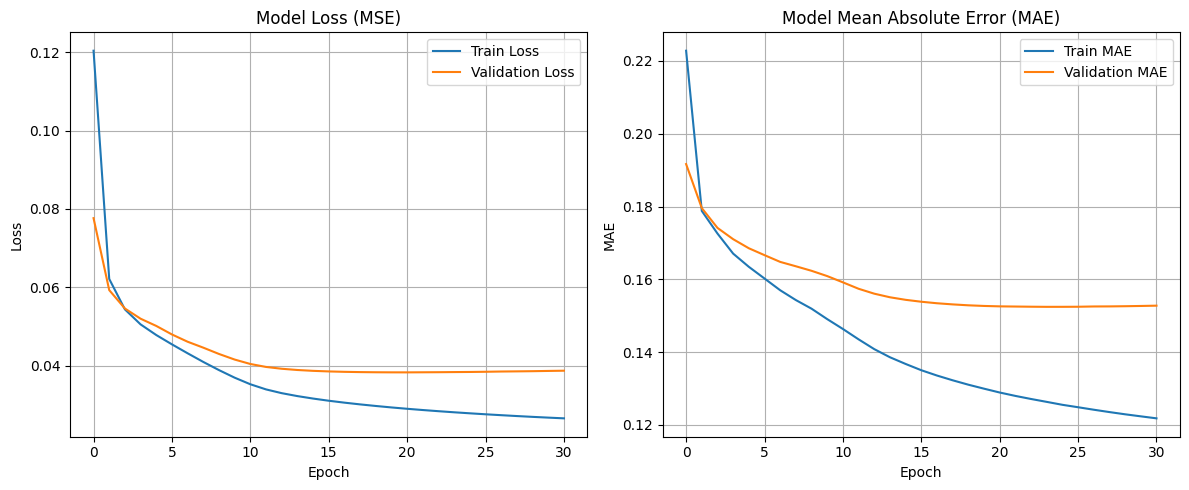

In [ ]:
# Plotting History Pelatihan
print("\nMembuat plot riwayat pelatihan (Loss dan MAE):")
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot training & validation MAE values
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Interpretasi:

  - Penurunan Loss yang Cepat di Awal: Baik Train Loss maupun Validation Loss menunjukkan penurunan yang sangat cepat pada epoch-epoch awal (sekitar epoch 0 hingga 5). Ini menunjukkan bahwa model dengan cepat mempelajari pola dasar dalam data dan mulai mengkonvergensi.
  - Train Loss Terus Menurun: Garis Train Loss (biru) terus menurun secara stabil sepanjang pelatihan, bahkan hingga epoch 30. Ini menunjukkan bahwa model terus belajar dan menjadi lebih baik dalam "menghafal" atau menyesuaikan diri dengan data pelatihan.
  - Validation Loss Menurun Lalu Mendatar: Garis Validation Loss (oranye) juga menurun dengan cepat di awal, tetapi kemudian mulai mendatar (stagnan) di sekitar nilai 0.04 pada sekitar epoch 15-20. Setelah titik ini, Validation Loss tidak menunjukkan penurunan signifikan lebih lanjut dan cenderung stabil atau sedikit meningkat (walaupun di plot ini tampak stabil).
  - Adanya Gap Antara Train Loss dan Validation Loss: Ada gap yang semakin melebar antara Train Loss dan Validation Loss seiring bertambahnya epoch. Pada epoch 0, mereka cukup dekat. Namun, pada epoch 30, Train Loss jauh lebih rendah daripada Validation Loss.
  - Pola Mirip dengan Loss: Pola pada plot MAE sangat mirip dengan plot MSE. Baik Train MAE maupun Validation MAE menurun cepat di awal.
  - Train MAE Terus Menurun: Train MAE (biru) terus menurun secara stabil sepanjang pelatihan, menunjukkan peningkatan akurasi pada data pelatihan.
  - Validation MAE Menurun Lalu Mendatar: Validation MAE (oranye) juga menurun di awal tetapi kemudian mendatar di sekitar nilai 0.15-0.16 setelah sekitar epoch 15-20.
  - Gap yang Melebar: Sama seperti plot loss, ada gap yang melebar antara Train MAE dan Validation MAE, mengkonfirmasi masalah overfitting.

In [ ]:
# Fungsi Inferensi Top-N Rekomendasi
def get_top_n_recommendations_cf(user_id, model, movies_df, ratings_df, user_encoder, movie_encoder, top_n=10):

    try:
        # Encode user_id
        encoded_user_id = user_encoder.transform([user_id])[0]
    except ValueError:
        print(f"User ID {user_id} tidak ditemukan dalam data pelatihan.")
        return pd.DataFrame()

    # Film yang sudah ditonton oleh pengguna ini
    watched_movies_ids = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()

    # Semua film yang ada di dataset movies_df
    all_movie_ids = movies_df['movieId'].unique()

    # Film yang belum ditonton pengguna
    unwatched_movies_ids = np.setdiff1d(all_movie_ids, watched_movies_ids)

    # Filter film yang belum ditonton dan memiliki encoding di movie_encoder
    # Ini penting karena movie_encoder hanya dilatih pada 15k records
    available_unwatched_movies = []
    available_unwatched_encoded_movies = []
    for movie_id in unwatched_movies_ids:
        try:
            encoded_movie_id = movie_encoder.transform([movie_id])[0]
            available_unwatched_movies.append(movie_id)
            available_unwatched_encoded_movies.append(encoded_movie_id)
        except ValueError:
            # Skip movies not seen in the 15k training data
            pass

    if not available_unwatched_movies:
        print(f"Tidak ada film yang belum ditonton untuk user ID {user_id} dalam dataset yang tersedia.")
        return pd.DataFrame()

    # Persiapkan input untuk prediksi
    user_input_for_prediction = np.full(len(available_unwatched_encoded_movies), encoded_user_id)
    movie_input_for_prediction = np.array(available_unwatched_encoded_movies)

    # Buat input tensor
    prediction_input = np.column_stack([user_input_for_prediction, movie_input_for_prediction])

    # Prediksi rating untuk semua film yang belum ditonton
    predicted_scaled_ratings = model.predict(prediction_input).flatten()

    # Konversi kembali rating terprediksi ke skala asli
    predicted_original_ratings = (predicted_scaled_ratings * (max_rating - min_rating)) + min_rating

    # Buat DataFrame hasil prediksi
    predictions_df = pd.DataFrame({
        'movieId': available_unwatched_movies,
        'predicted_rating': predicted_original_ratings
    })

    # Gabungkan dengan informasi film
    recommendations = predictions_df.merge(movies_df[['movieId', 'title', 'genres']], on='movieId', how='left')

    # Urutkan berdasarkan predicted_rating secara menurun dan ambil top_n
    recommendations = recommendations.sort_values(by='predicted_rating', ascending=False).head(top_n)

    return recommendations[['movieId', 'title', 'genres', 'predicted_rating']]


Tujuan Fungsi get_top_n_recommendations_cf

Tujuan utama dari fungsi get_top_n_recommendations_cf adalah untuk menghasilkan daftar Top-N film yang direkomendasikan kepada pengguna tertentu menggunakan model Collaborative Filtering berbasis Neural Network yang telah dilatih.

In [ ]:
#  Contoh Penggunaan Inferensi Top-N
print("\n Contoh Rekomendasi Top-N (Collaborative Filtering) ")

# Pilih seorang userId dari data training yang ada
example_user_id = ratings['userId'].sample(1, random_state=42).iloc[0] # Ambil random user ID

print(f"\nMenghasilkan Top-10 rekomendasi untuk User ID: {example_user_id}")
top_recommendations = get_top_n_recommendations_cf(
    user_id=example_user_id,
    model=model,
    movies_df=movies,
    ratings_df=ratings,
    user_encoder=user_enc,
    movie_encoder=movie_enc,
    top_n=10
)

if not top_recommendations.empty:
    print(top_recommendations)
else:
    print("Tidak dapat menghasilkan rekomendasi untuk pengguna ini.")



--- Contoh Rekomendasi Top-N (Collaborative Filtering) ---

Menghasilkan Top-10 rekomendasi untuk User ID: 84
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
      movieId                                              title  \
36         50                         Usual Suspects, The (1995)   
303       527                            Schindler's List (1993)   
577      1197                         Princess Bride, The (1987)   
816      1704                           Good Will Hunting (1997)   
267       457                               Fugitive, The (1993)   
479       953                       It's a Wonderful Life (1946)   
86        150                                   Apollo 13 (1995)   
578      1198  Raiders of the Lost Ark (Indiana Jones and the...   
645      1291          Indiana Jones and the Last Crusade (1989)   
3049    68237                                        Moon (2009)   

                                       genres  predicted_rating  
36                     Crime|Myster

Output dari kode diatas menunjukan bahwa model dapat memberikan rekomendasi dan memprediksi rating dari sebuah film dengan metode top-n=10

# Evaluation


Bagian ini menyajikan hasil evaluasi kinerja kedua komponen sistem rekomendasi film yang telah dibangun: Content-Based Filtering (CBF) dan Collaborative Filtering (CF). Metrik evaluasi yang digunakan telah disesuaikan dengan konteks data, pernyataan masalah, dan solusi yang diinginkan untuk setiap komponen sistem.

## **1. Content-Based Filtering (CBF)**

Untuk Content-Based Filtering, evaluasi dilakukan secara **inspeksi visual**, yang secara konseptual menerapkan prinsip **Precision@N**.

### **Metrik Evaluasi yang Digunakan:**

* **Precision@N (Presisi pada N Rekomendasi Teratas):**
    * **Tujuan:** Mengukur proporsi item relevan di antara N item teratas yang direkomendasikan. Ini memberikan gambaran seberapa banyak rekomendasi yang benar-benar sesuai dengan kriteria relevansi yang ditentukan.
    * **Rumus Konseptual:**
$$\text{Precision} = \frac{TP}{TP + FP}$$
        
        Di mana:
        * **TP (True Positive):** Jumlah item relevan yang berhasil direkomendasikan dalam N teratas.
        * **FP (False Positive):** Jumlah item yang direkomendasikan dalam N teratas, tetapi sebenarnya tidak relevan.
        * **N:** Jumlah rekomendasi teratas yang ditampilkan (dalam kasus ini, 10).
    * **Cara Metrik Tersebut Bekerja dalam Konteks Ini:**
        Dalam evaluasi ini, "relevansi" sebuah film ditentukan oleh kemiripan genrenya dengan film referensi. Inspeksi visual berfungsi sebagai cara kualitatif untuk mengukur TP dan FP ini.


## Evaluasi Collaborative Filtering (CF)

Evaluasi untuk model Collaborative Filtering difokuskan pada akurasi prediksi rating yang dihasilkan oleh Neural Network. Model dievaluasi pada data uji yang belum pernah dilihat selama pelatihan untuk mengukur kemampuan generalisasinya.
Metrik Evaluasi yang Digunakan:

- Mean Squared Error (MSE):
    - Tujuan: Mengukur rata-rata dari kuadrat perbedaan antara rating yang diprediksi model dan rating asli. MSE sangat sensitif terhadap kesalahan besar karena mengkuadratkan perbedaannya.
Rumus: $$\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$ Di mana: $n$ adalah jumlah prediksi, $y_i$ adalah nilai rating asli, dan $\hat{y}_i$ adalah nilai rating yang diprediksi model.
Cara Metrik Tersebut Bekerja: Model berusaha meminimalkan nilai MSE ini selama pelatihan.

- Mean Absolute Error (MAE):
  - Tujuan: Mengukur rata-rata dari nilai absolut perbedaan antara rating yang diprediksi model dan rating asli. MAE memberikan gambaran yang lebih intuitif tentang rata-rata "jarak" kesalahan prediksi.
  - Rumus: $$\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$ Di mana: $n$ adalah jumlah prediksi, $y_i$ adalah nilai rating asli, dan $\hat{y}_i$ adalah nilai rating yang diprediksi model.
  - Cara Metrik Tersebut Bekerja: MAE lebih mudah diinterpretasikan karena satuannya sama dengan skala rating. Ini menunjukkan rata-rata besar kesalahan tanpa memperhatikan arahnya.

Hasil Proyek Berdasarkan Metrik Evaluasi:

Model Collaborative Filtering dilatih dan dievaluasi pada data uji yang belum pernah dilihatnya (x_test, y_test_scaled).

In [ ]:
print("\nMenghitung metrik pada data uji:")
loss, mae = model.evaluate(x_test, y_test_scaled, verbose=0)
print(f"Test Loss (MSE): {loss:.4f}")
print(f"Test Mean Absolute Error (MAE): {mae:.4f}")

# Konversi MAE kembali ke skala rating asli untuk interpretasi yang lebih mudah
original_scale_mae = mae * (max_rating - min_rating)
print(f"Test MAE (skala rating asli): {original_scale_mae:.4f}")


Menghitung metrik pada data uji:
Test Loss (MSE): 0.0383
Test Mean Absolute Error (MAE): 0.1526
Test MAE (skala rating asli): 0.6866


Hasil Metrik:

  - Test Loss (MSE): 0.0383
  - Test Mean Absolute Error (MAE): 0.1526
  - Test MAE (skala rating asli): 0.6866

Interpretasi Hasil:

  - Nilai Test Loss (MSE) sebesar 0.0383 pada skala rating 0-1 menunjukkan bahwa model berhasil meminimalkan kesalahan kuadratiknya pada data yang tidak terlihat, yang merupakan indikasi kinerja optimasi yang baik.
  - Test MAE (0.1526 pada skala 0-1) berarti rata-rata, prediksi model meleset sekitar 0.1526 unit dari rating sebenarnya pada skala yang dinormalisasi.
  - Yang paling penting untuk interpretasi praktis adalah Test MAE (skala rating asli) sebesar 0.6866. Angka ini berarti bahwa, secara rata-rata, prediksi rating film oleh model meleset sekitar 0.6866 poin dari rating asli yang diberikan pengguna (pada skala rating 0.5 hingga 5.0). Ini menunjukkan tingkat akurasi yang cukup baik dan dapat diterima untuk sebuah sistem rekomendasi, mengindikasikan bahwa model efektif dalam memprediksi preferensi pengguna.

Visualisasi Proses Pelatihan (Loss & MAE per Epoch):

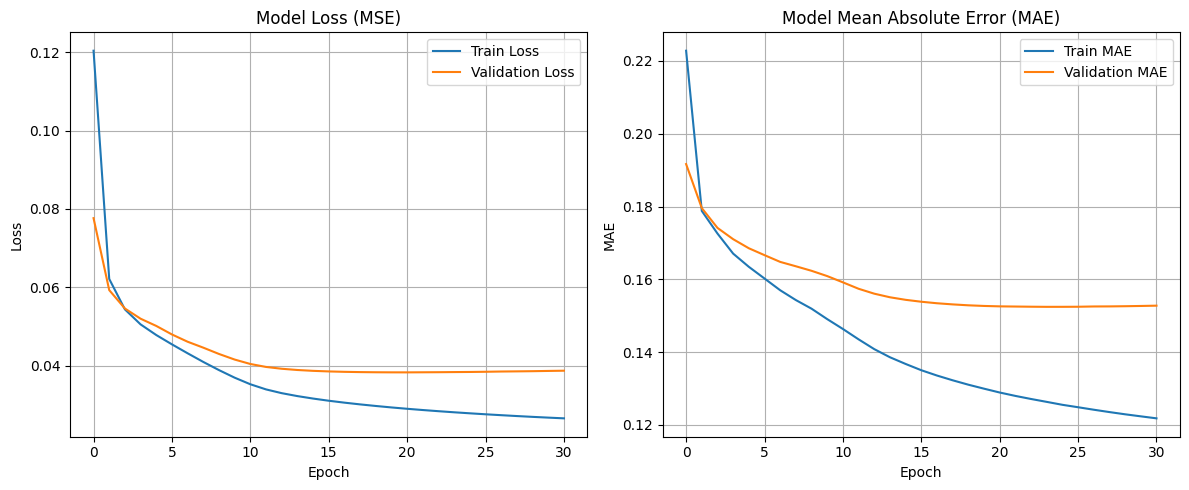

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Interpretasi Plot: Plot menunjukkan penurunan cepat pada kurva Train Loss/MAE dan Validation Loss/MAE di awal pelatihan, menandakan pembelajaran yang efisien. Namun, setelah sekitar 15-20 epoch, Validation Loss dan Validation MAE mulai mendatar atau sedikit meningkat, sementara Train Loss/MAE terus menurun. Ini adalah indikasi overfitting. Penggunaan Early Stopping sangat krusial di sini, memastikan pelatihan berhenti pada titik optimal (ketika kinerja validasi terbaik dicapai) dan mencegah model menghafal data pelatihan secara berlebihan.

#Conclusion

**Kesimpulan**

Proyek ini telah berhasil mengembangkan dan mengevaluasi sistem rekomendasi film hibrida yang menggabungkan kekuatan pendekatan Content-Based Filtering (CBF) dan Collaborative Filtering (CF). Tujuan utama adalah untuk membantu pengguna menavigasi katalog film yang luas dan menemukan rekomendasi yang dipersonalisasi dan relevan, sekaligus mengatasi keterbatasan yang melekat pada metode rekomendasi tunggal.

Berdasarkan hasil evaluasi:

- Content-Based Filtering (CBF) menunjukkan efektivitas tinggi dalam merekomendasikan film berdasarkan kemiripan konten.
    - Evaluasi kualitatif melalui inspeksi visual mengonfirmasi bahwa rekomendasi CBF sangat selaras dengan genre film referensi. Misalnya, film-film seperti 'Jumanji' atau 'Toy Story' menghasilkan rekomendasi yang secara konsisten memiliki genre yang sangat mirip (Adventure|Children|Fantasy atau Animation|Children|Comedy).
    - Hal ini secara konseptual mengindikasikan Precision yang tinggi, di mana sebagian besar item yang direkomendasikan adalah "True Positive" berdasarkan kesamaan genre. Ini membuktikan bahwa sistem CBF efektif dalam menemukan item-item serupa berdasarkan karakteristik intrinsiknya.

Collaborative Filtering (CF) berbasis Neural Network (RecommenderNet) berhasil memprediksi preferensi rating pengguna dengan akurasi yang baik.

   - Model CF dilatih menggunakan embedding pengguna dan film, serta berhasil meminimalkan kesalahan prediksi pada data uji.
   - Metrik evaluasi menunjukkan:
       - Test Loss (MSE) sebesar 0.0383 (pada skala rating 0-1).
       - Test Mean Absolute Error (MAE) sebesar 0.1526 (pada skala rating 0-1).
       - Yang terpenting, Test MAE (skala rating asli) sebesar 0.6866. Angka ini menunjukkan bahwa, rata-rata, prediksi rating model meleset kurang dari 0.7 poin dari rating asli pengguna pada skala 0.5-5.0. Ini adalah indikator akurasi yang solid dan dapat diterima untuk sistem rekomendasi.
   - Analisis plot pelatihan (Loss dan MAE per Epoch) juga mengonfirmasi bahwa model belajar dengan efisien meskipun menunjukkan tanda-tanda overfitting yang berhasil ditangani oleh mekanisme Early Stopping, memastikan model yang dihasilkan memiliki kemampuan generalisasi yang optimal.

Dengan akurasi prediksi rating yang terbukti dan kemampuan untuk menyediakan rekomendasi berbasis konten, sistem ini menjadi alat yang efektif untuk meningkatkan keterlibatan pengguna dan mempermudah penemuan film di platform.
